In [1]:
import matplotlib.pyplot as plt      
from mpl_toolkits import mplot3d
import os
import sys
import glob
import time
import shutil
import gym
from gym import error, spaces, utils
import numpy as np
import math
from pathlib import Path

In [2]:
import gym_fish

In [3]:
from gym_fish.envs.lib import pyflare as fl

In [4]:
Experiment_name = 'test random vel -180,180 forward+ energy minimize'
Experiment_note = """
"""

In [5]:
gpuId = 3
frame_skip = 200
theta = np.array([-180,180])
vel_theta = np.array([-180,180])
random_vel = np.array([0,0.3])
radius=1.0
max_time = 10
action_max= 2
done_dist = 0.2
dist_distri_param =np.array([0,0])
couple_mode =  fl.COUPLE_MODE.TWO_WAY
ratio = 5/frame_skip*(max_time/10)
use_com=False
import torch
torch.cuda.set_device(gpuId)

In [6]:
wr = 0.0*np.array([1.0,0.5])
wp = 1.0*np.array([0.0,1.0])
wa = 0.1
live_penality = 0.0

In [7]:
num_train_steps= int(2e6*ratio)
replay_buffer_capacity=int(2e6*ratio)
num_seed_steps=int(2048*ratio)
eval_frequency=int(20000*ratio)
num_eval_episodes=1
device="cuda"
# logger
log_frequency=1
log_save_tb=True
# video recorder
save_video=False
seed=1

In [8]:

discount=0.99
init_temperature=0.2
alpha_lr=3e-4
alpha_betas=[0.9, 0.999]
actor_lr=3e-4
actor_betas=[0.9, 0.999]
actor_update_frequency=1
critic_lr=3e-4
critic_betas=[0.9, 0.999]
critic_tau=0.005
critic_target_update_frequency=2
batch_size=int(2048*ratio)

#######################################
learnable_temperature=False

# critic settings
critic_hidden_dim=128
critic_hidden_depth=2
# actor settings
actor_hidden_depth=2
actor_hidden_dim=128
actor_log_std_bounds=[-5, 2]

evaluate_save_data = False
evaluate_save_fluid = False



In [9]:
os.chdir(Path(os.getcwd()+"/../").resolve())
print(os.getcwd())

/root/pytorch_fish


### Import Settings

In [10]:
cwd = os.getcwd()+"/"
data_folder =cwd+ 'py_data/'
json_folder =data_folder+'jsons/'
path_folder =json_folder+'paths/'
scripts_folder = cwd+'scripts/'

In [11]:
fluid_json = json_folder+'fluid_param_1.0.json'
rigid_json = json_folder+'rigids_4_30_new.json'
path_json = str(Path("./py_data/jsons/paths/line.json").resolve())
print(fluid_json)
print(rigid_json)
print(path_json)

/root/pytorch_fish/py_data/jsons/fluid_param_1.0.json
/root/pytorch_fish/py_data/jsons/rigids_4_30_new.json
/root/pytorch_fish/py_data/jsons/paths/line.json


In [12]:
def plot_infos(infos,title,reward_fig_name):
    dd = {k:[] for k in infos[0].keys()}
    for info in infos:
        for k in info.keys():
            dd[k].append(info[k])
    plt.figure()
    for k in dd.keys():
        if k=='action_penality':
            plt.plot(np.arange(0,len(dd[k])),[kkk  for kkk in dd[k]],label=k)
        else:
            plt.plot(np.arange(0,len(dd[k])),dd[k],label=k)
    plt.legend()
    plt.title(title)
    plt.savefig(reward_fig_name)
    plt.show()

### Output Settings

In [13]:
store_folder_name = time.strftime('%Y-%m-%d/',time.localtime(time.time()))+Experiment_name+'_'+time.strftime('%Y-%m-%d %H:%M/',time.localtime(time.time()))
imgs_folder_name = 'imgs/'
rl_data_folder_name = 'rl_data/'
rl_data_all_name='collected_o_a.npz'
network_folder_name = 'networks/'
store_folder = cwd+'output_data/'+store_folder_name
imgs_folder = store_folder+imgs_folder_name
rl_data_folder= store_folder+rl_data_folder_name
network_folder = store_folder+network_folder_name

if not os.path.exists(store_folder):
    os.makedirs(store_folder)
if not os.path.exists(imgs_folder):
    os.makedirs(imgs_folder)
if not os.path.exists(rl_data_folder):
    os.makedirs(rl_data_folder)
if not os.path.exists(network_folder):
    os.makedirs(network_folder)

## Saving sources

In [14]:
save_sources = True
sources_folder_name = ['py_data','scripts']
if save_sources==True:
    for fn in sources_folder_name:
        shutil.copytree(cwd+fn,store_folder+'sources/'+fn)
with open(store_folder+'note.txt','w+') as f:
    f.write(time.strftime('%Y-%m-%d %H:%M\n',time.localtime(time.time())))
    f.write(Experiment_note)

### RL_TRAINING Setup

In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import math
import os
import sys
import time
import pickle as pkl

from sac.logger import Logger
from sac.agent.replay_buffer import ReplayBuffer
from sac.agent import utils

## RL Begin

In [16]:
from sac.agent.sac import SACAgent
from sac.agent.critic import DoubleQCritic
from sac.agent.actor import DiagGaussianActor

In [17]:
from gym_fish.envs import FishEnv
env=gym.make('fish-v0', 
                  gpuId=gpuId,
                        couple_mode=couple_mode,frame_skip=frame_skip,radius=radius,
                       theta=theta,action_max=action_max,random_vel=random_vel,max_time=max_time,
                       fluid_json=fluid_json,wp=wp,wr=wr,wa=wa,live_penality =live_penality,
                       rigid_json=rigid_json,vel_theta = vel_theta,
                       done_dist=done_dist,dist_distri_param=dist_distri_param,use_com=use_com
               
                   )
# agent settings
obs_dim=env.observation_space.shape[0] # to be specified later
action_dim=env.action_space.shape[0] # to be specified later
action_range=[
        float(env.action_space.low.min()),
        float(env.action_space.high.max())
    ] # to be specified later
env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()

array([1., 0., 0.])

In [18]:
algo = 'SAC'
algofoler=algo+'/'
if not os.path.exists(network_folder+algofoler):
    os.makedirs(network_folder+algofoler)
if not os.path.exists(network_folder+algofoler+'imgs/'):
    os.makedirs(network_folder+algofoler+'imgs/')
if not os.path.exists(network_folder+algofoler+'imgs/trajs/'):
    os.makedirs(network_folder+algofoler+'imgs/trajs/')
if not os.path.exists(network_folder+algofoler+'imgs/rewards/'):
    os.makedirs(network_folder+algofoler+'imgs/rewards/')
if not os.path.exists(network_folder+algofoler+'models/'):
    os.makedirs(network_folder+algofoler+'models/')

tb_folder =  network_folder+algofoler
model_folder = network_folder+algofoler+'models/'
result_img_folder = network_folder+algofoler+'imgs/'

In [19]:
logger = Logger(tb_folder,
                             save_tb=log_save_tb,
                             log_frequency=log_frequency,
                             agent="sac")
critic_network = DoubleQCritic(obs_dim,action_dim,critic_hidden_dim,critic_hidden_depth)

actor_network = DiagGaussianActor(obs_dim,action_dim,actor_hidden_dim,actor_hidden_depth,actor_log_std_bounds)

replay_buffer = ReplayBuffer(env.observation_space.shape,env.action_space.shape,int(replay_buffer_capacity),device)

agent = SACAgent(obs_dim,action_dim,action_range,device,critic_network,actor_network,replay_buffer,discount,init_temperature,alpha_lr,alpha_betas,actor_lr,actor_betas,actor_update_frequency,critic_lr,critic_betas,critic_tau,critic_target_update_frequency,batch_size,learnable_temperature)

utils.set_seed_everywhere(seed)

In [20]:
step = 0
next_eval_steps= eval_frequency

In [21]:
 def collect_traj(seed_steps=False):
        obs = env.reset()
        done = False
        reward = 0
        samples = []
        while not done:
            if seed_steps:
                action = env.action_space.sample()
            else:
                with utils.eval_mode(agent):
                        action = agent.act(obs, sample=True)
            next_obs, reward, done, _ = env.step(action)
            samples.append((obs,action,next_obs,reward,done))
            obs = next_obs
            if done:
                if (not np.isfinite(obs).all()):
                    print('bad observation, try new traj')
                    samples.clear()
                    obs = env.reset()
                    done = False
                    reward = 0 
        return samples

In [22]:
def collect_seed_samples():
        step = 0 
        while step<num_seed_steps:
            samples = collect_traj(seed_steps=True)
            for sample in samples:
                obs,action,next_obs,reward,done = sample
                agent.replay_buffer.add(obs, action, reward, next_obs,done,done)
                step+=1
                if step>=num_seed_steps:
                    break
        print("Collect seed samples complete. Step: ",step," Seed steps:",num_seed_steps)

In [23]:
def evaluate():
        average_episode_reward = 0
        reward_fig_name =result_img_folder+'rewards/'+"steps_{0}.png".format(step)
        traj_fig_name =result_img_folder+'trajs/'+"steps_{0}.png".format(step)
        best_rewards = -9999
        for episode in range(num_eval_episodes):
            print("Evaluating episode " + str(episode) +" ....")
            obs = env.reset()
            agent.reset()
            done = False
            episode_reward = 0
            infos = []
            while not done:
                with utils.eval_mode(agent):
                    action = agent.act(obs, sample=False)
                if evaluate_save_data:
                    obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
                else:
                    obs, reward, done, info = env.step(action)
                infos.append(info)
                # video_recorder.record(env)
                episode_reward += reward
            if episode_reward>best_rewards:
                best_rewards = episode_reward
                plot_infos(infos,title=str(step),reward_fig_name=reward_fig_name)
                env.plot3d(title=str(step),fig_name = traj_fig_name)
            average_episode_reward += episode_reward
            # video_recorder.save(f'{step}.mp4')
        average_episode_reward /= num_eval_episodes
        logger.log('eval/episode_reward', average_episode_reward,step)
        logger.dump(step,ty='eval')

### RL Train

In [24]:
!./clean_visdata.sh

rm: cannot remove './data/vis_data/Objects/*': No such file or directory
rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


In [25]:
collect_seed_samples()
episode, episode_reward= 0, 0
start_time = time.time()

Collect seed samples complete. Step:  51  Seed steps: 51


| train | E: 1 | S: 49 | R: -54.0202 | D: 278.4 s | BR: -0.8667 | ALOSS: 0.4213 | CLOSS: 1.1630 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7655
| train | E: 2 | S: 95 | R: 1.0141 | D: 254.4 s | BR: -0.7880 | ALOSS: 2.6702 | CLOSS: 1.7991 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.4727
| train | E: 3 | S: 135 | R: -7.1958 | D: 237.8 s | BR: -0.5794 | ALOSS: 4.2796 | CLOSS: 3.3923 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.2917
| train | E: 4 | S: 153 | R: 1.9747 | D: 97.7 s | BR: -0.4896 | ALOSS: 3.7656 | CLOSS: 2.1979 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1409
| train | E: 5 | S: 181 | R: 2.7737 | D: 156.5 s | BR: -0.4377 | ALOSS: 2.9773 | CLOSS: 2.9751 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0970
| train | E: 6 | S: 231 | R: -65.2972 | D: 313.8 s | BR: -0.4897 | ALOSS: 1.5640 | CLOSS: 2.7159 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7633
| train | E: 7 | S: 281 | R: -23.6448 | D: 332.1 s | BR: -0.5550 | ALOSS: 1.8525 | CLOSS: 3.8057 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8236
| train |

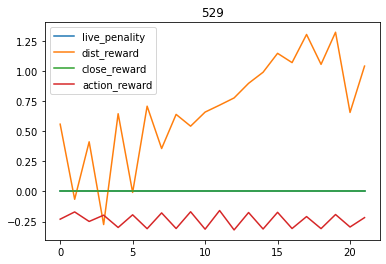

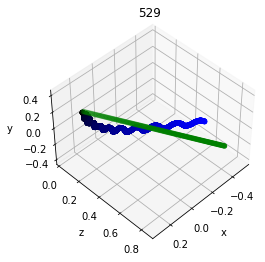

| eval  | E: 14 | S: 529 | R: 9.8620
| train | E: 15 | S: 529 | R: 5.0384 | D: 208.8 s | BR: -0.3580 | ALOSS: -10.3507 | CLOSS: 9.2586 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.4492
| train | E: 16 | S: 545 | R: 6.9745 | D: 263.7 s | BR: -0.3082 | ALOSS: -11.1552 | CLOSS: 10.2568 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.5901
| train | E: 17 | S: 595 | R: -6.2343 | D: 276.4 s | BR: -0.3241 | ALOSS: -11.3969 | CLOSS: 9.5298 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.6817
| train | E: 18 | S: 620 | R: -6.8646 | D: 140.6 s | BR: -0.3542 | ALOSS: -10.9342 | CLOSS: 9.6670 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.3406
| train | E: 19 | S: 652 | R: -3.7706 | D: 173.6 s | BR: -0.3304 | ALOSS: -10.9282 | CLOSS: 7.0689 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.4587
| train | E: 20 | S: 671 | R: 0.5919 | D: 109.1 s | BR: -0.2711 | ALOSS: -11.3003 | CLOSS: 8.4934 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.4617
| train | E: 21 | S: 695 | R: 3.9823 | D: 156.4 s | BR: -0.2788 | ALOSS: -11.4415 | CLOSS: 9.51

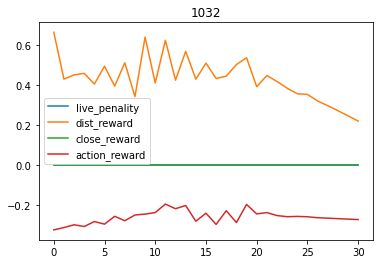

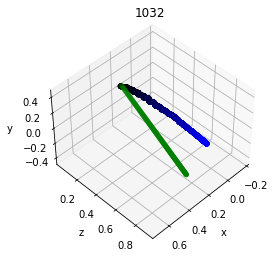

| eval  | E: 29 | S: 1032 | R: 5.3016
| train | E: 30 | S: 1032 | R: -3.1503 | D: 285.9 s | BR: -0.2331 | ALOSS: -13.9194 | CLOSS: 12.9913 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.8533
| train | E: 31 | S: 1082 | R: -6.7441 | D: 444.4 s | BR: -0.2539 | ALOSS: -13.6550 | CLOSS: 12.0778 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.5314
| train | E: 32 | S: 1127 | R: 2.5785 | D: 262.4 s | BR: -0.2406 | ALOSS: -14.0569 | CLOSS: 9.4261 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.2401
| train | E: 33 | S: 1177 | R: -8.3742 | D: 316.1 s | BR: -0.1991 | ALOSS: -15.2161 | CLOSS: 11.9961 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.1849
| train | E: 34 | S: 1227 | R: -7.9890 | D: 382.9 s | BR: -0.1991 | ALOSS: -15.7219 | CLOSS: 11.0080 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.1119
| train | E: 35 | S: 1277 | R: -11.9873 | D: 356.5 s | BR: -0.2046 | ALOSS: -14.4696 | CLOSS: 9.7569 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 0.8313
| train | E: 36 | S: 1314 | R: -9.5625 | D: 201.3 s | BR: -0.2283 | ALOSS: -12.964

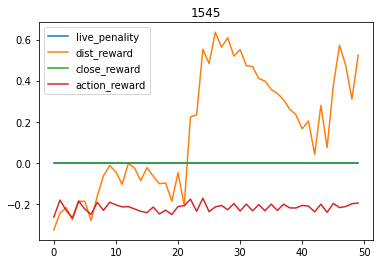

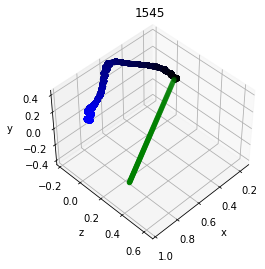

| eval  | E: 42 | S: 1545 | R: -3.2596
| train | E: 43 | S: 1545 | R: -5.7563 | D: 180.2 s | BR: -0.1783 | ALOSS: -10.6778 | CLOSS: 5.3625 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.2935
| train | E: 44 | S: 1567 | R: 9.4563 | D: 409.1 s | BR: -0.1855 | ALOSS: -10.6971 | CLOSS: 4.6649 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4110
| train | E: 45 | S: 1589 | R: 8.3746 | D: 115.8 s | BR: -0.1745 | ALOSS: -10.6670 | CLOSS: 4.6283 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.2971
| train | E: 46 | S: 1619 | R: 8.0586 | D: 169.9 s | BR: -0.1664 | ALOSS: -10.1937 | CLOSS: 5.1609 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4475
| train | E: 47 | S: 1647 | R: 7.1272 | D: 148.7 s | BR: -0.1599 | ALOSS: -10.0706 | CLOSS: 4.6476 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.5193
| train | E: 48 | S: 1661 | R: 12.6272 | D: 75.3 s | BR: -0.1431 | ALOSS: -10.3085 | CLOSS: 3.8504 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4915
| train | E: 49 | S: 1711 | R: -0.6108 | D: 273.1 s | BR: -0.1473 | ALOSS: -10.2305 | CLOS

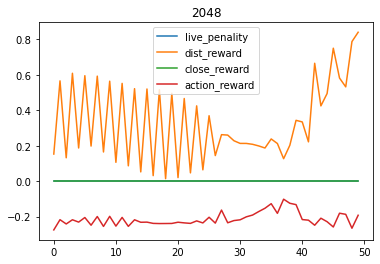

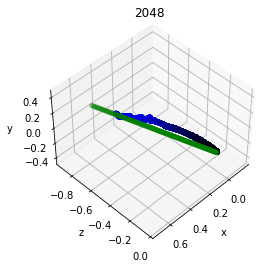

| eval  | E: 59 | S: 2048 | R: 6.0394
| train | E: 60 | S: 2048 | R: 5.2346 | D: 220.3 s | BR: -0.1007 | ALOSS: -12.0956 | CLOSS: 6.3440 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4236
| train | E: 61 | S: 2073 | R: 1.5503 | D: 416.2 s | BR: -0.0849 | ALOSS: -11.6030 | CLOSS: 5.9507 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.5146
| train | E: 62 | S: 2123 | R: -22.1261 | D: 277.4 s | BR: -0.1062 | ALOSS: -11.8612 | CLOSS: 4.3395 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.5135
| train | E: 63 | S: 2173 | R: -3.3246 | D: 276.2 s | BR: -0.1019 | ALOSS: -12.1657 | CLOSS: 5.6733 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4779
| train | E: 64 | S: 2204 | R: 6.7432 | D: 169.3 s | BR: -0.1178 | ALOSS: -11.6887 | CLOSS: 5.2813 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4544
| train | E: 65 | S: 2222 | R: 3.0693 | D: 96.4 s | BR: -0.1087 | ALOSS: -11.3709 | CLOSS: 5.0510 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.3869
| train | E: 66 | S: 2262 | R: 2.6182 | D: 225.9 s | BR: -0.1134 | ALOSS: -11.1507 | CLOSS

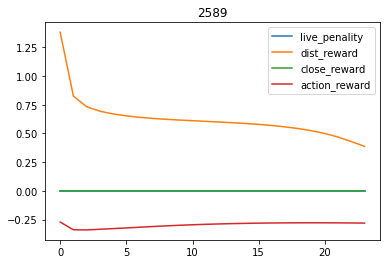

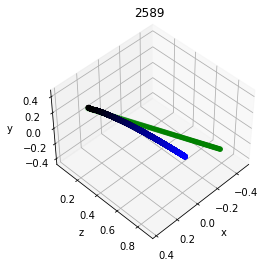

| eval  | E: 74 | S: 2589 | R: 7.8869
| train | E: 75 | S: 2589 | R: -15.5927 | D: 291.3 s | BR: -0.0665 | ALOSS: -11.6953 | CLOSS: 4.8992 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4258
| train | E: 76 | S: 2636 | R: 1.4246 | D: 396.7 s | BR: -0.0588 | ALOSS: -11.2623 | CLOSS: 4.1777 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.3766
| train | E: 77 | S: 2686 | R: -16.4397 | D: 293.6 s | BR: -0.0661 | ALOSS: -11.1438 | CLOSS: 5.0763 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4549
| train | E: 78 | S: 2714 | R: 8.7635 | D: 161.5 s | BR: -0.0688 | ALOSS: -11.1726 | CLOSS: 5.1674 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4171
| train | E: 79 | S: 2746 | R: 5.0607 | D: 179.6 s | BR: -0.0737 | ALOSS: -11.1945 | CLOSS: 4.2896 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4141
| train | E: 80 | S: 2773 | R: -14.8881 | D: 149.8 s | BR: -0.0780 | ALOSS: -10.9601 | CLOSS: 3.6271 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4557
| train | E: 81 | S: 2823 | R: -2.0629 | D: 276.6 s | BR: -0.0725 | ALOSS: -10.6155 | 

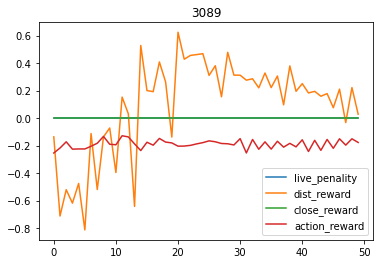

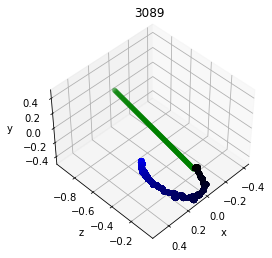

| eval  | E: 87 | S: 3089 | R: -4.8601
| train | E: 88 | S: 3089 | R: 5.3079 | D: 169.9 s | BR: -0.0716 | ALOSS: -9.9762 | CLOSS: 3.3192 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4800
| train | E: 89 | S: 3102 | R: 11.6213 | D: 358.3 s | BR: -0.0509 | ALOSS: -10.6585 | CLOSS: 3.6053 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.5394
| train | E: 90 | S: 3145 | R: 5.8505 | D: 252.4 s | BR: -0.0896 | ALOSS: -10.7842 | CLOSS: 2.6252 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4291
| train | E: 91 | S: 3189 | R: 3.1456 | D: 270.4 s | BR: -0.0615 | ALOSS: -11.2476 | CLOSS: 3.5248 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.5042
| train | E: 92 | S: 3227 | R: 6.4877 | D: 237.4 s | BR: -0.0388 | ALOSS: -10.9690 | CLOSS: 3.9582 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.3858
| train | E: 93 | S: 3277 | R: -2.4508 | D: 303.9 s | BR: -0.0478 | ALOSS: -10.7416 | CLOSS: 3.7106 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.3769
| train | E: 94 | S: 3313 | R: 3.9013 | D: 216.5 s | BR: -0.0285 | ALOSS: -11.3371 | CLOSS

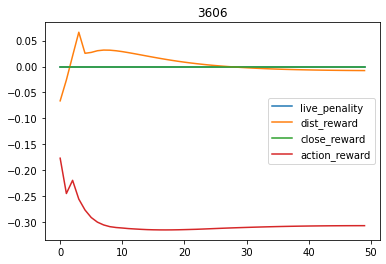

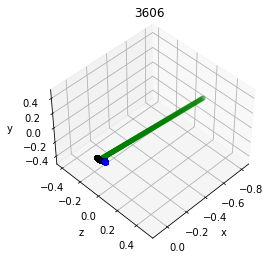

| eval  | E: 101 | S: 3606 | R: -14.8450
| train | E: 102 | S: 3606 | R: -8.2617 | D: 314.3 s | BR: -0.0338 | ALOSS: -11.1163 | CLOSS: 2.7792 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4588
| train | E: 103 | S: 3632 | R: 8.6295 | D: 501.0 s | BR: -0.0370 | ALOSS: -10.1356 | CLOSS: 3.0633 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4142
| train | E: 104 | S: 3659 | R: 10.0128 | D: 143.8 s | BR: -0.0162 | ALOSS: -10.6624 | CLOSS: 2.6002 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4004
| train | E: 105 | S: 3683 | R: 9.2834 | D: 138.3 s | BR: -0.0216 | ALOSS: -10.8581 | CLOSS: 2.6393 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4213
| train | E: 106 | S: 3707 | R: 8.0122 | D: 129.4 s | BR: -0.0084 | ALOSS: -11.2262 | CLOSS: 2.5274 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4211
| train | E: 107 | S: 3735 | R: 9.1536 | D: 161.3 s | BR: -0.0385 | ALOSS: -10.7010 | CLOSS: 3.4300 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4159
| train | E: 108 | S: 3785 | R: 3.9910 | D: 271.4 s | BR: -0.0188 | ALOSS: -10.63

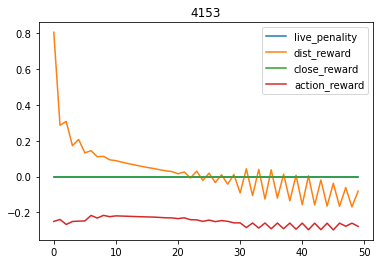

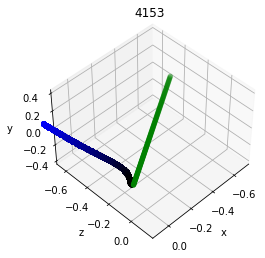

| eval  | E: 117 | S: 4153 | R: -11.0812
| train | E: 118 | S: 4153 | R: 4.5762 | D: 303.6 s | BR: 0.0174 | ALOSS: -10.4267 | CLOSS: 2.8968 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4643
| train | E: 119 | S: 4177 | R: 7.1981 | D: 420.1 s | BR: -0.0375 | ALOSS: -10.5660 | CLOSS: 3.1649 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4655
| train | E: 120 | S: 4198 | R: 10.4866 | D: 111.5 s | BR: 0.0030 | ALOSS: -10.0049 | CLOSS: 2.9949 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4344
| train | E: 121 | S: 4223 | R: 8.6683 | D: 132.7 s | BR: -0.0203 | ALOSS: -9.6398 | CLOSS: 1.9899 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4624
| train | E: 122 | S: 4273 | R: 2.5077 | D: 273.8 s | BR: 0.0031 | ALOSS: -9.6350 | CLOSS: 1.8603 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.5538
| train | E: 123 | S: 4297 | R: 8.1403 | D: 141.9 s | BR: 0.0030 | ALOSS: -10.5378 | CLOSS: 2.6992 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.5443
| train | E: 124 | S: 4337 | R: 4.9068 | D: 233.9 s | BR: -0.0106 | ALOSS: -10.4602 | CL

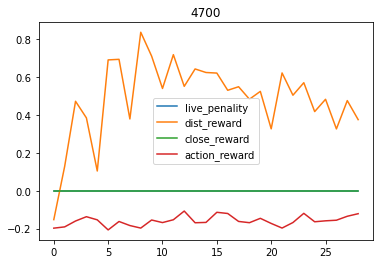

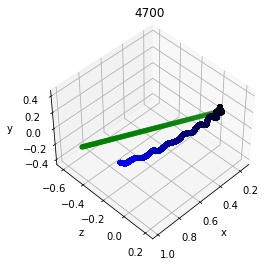

| eval  | E: 134 | S: 4700 | R: 9.4926
| train | E: 135 | S: 4700 | R: 2.0045 | D: 271.6 s | BR: 0.0219 | ALOSS: -9.9104 | CLOSS: 1.4023 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.5803
| train | E: 136 | S: 4722 | R: 7.2574 | D: 285.5 s | BR: 0.0076 | ALOSS: -9.7954 | CLOSS: 2.2300 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6336
| train | E: 137 | S: 4747 | R: 8.3868 | D: 138.5 s | BR: 0.0304 | ALOSS: -9.2069 | CLOSS: 2.2700 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6148
| train | E: 138 | S: 4775 | R: 5.3002 | D: 161.6 s | BR: 0.0237 | ALOSS: -9.3189 | CLOSS: 1.3568 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.5636
| train | E: 139 | S: 4817 | R: -2.4439 | D: 241.0 s | BR: -0.0114 | ALOSS: -10.0881 | CLOSS: 2.1764 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4858
| train | E: 140 | S: 4840 | R: 9.9017 | D: 125.6 s | BR: -0.0347 | ALOSS: -9.7989 | CLOSS: 2.9551 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.4700
| train | E: 141 | S: 4862 | R: 9.9751 | D: 118.0 s | BR: 0.0018 | ALOSS: -9.5774 | CLOSS: 2.

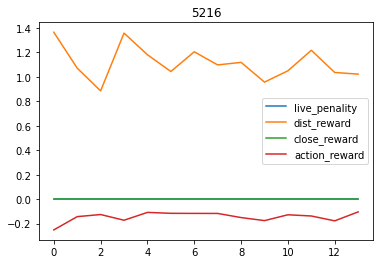

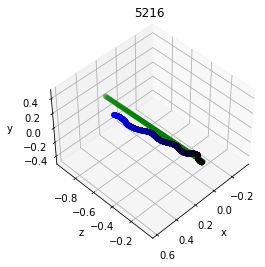

| eval  | E: 152 | S: 5216 | R: 13.5834
| train | E: 153 | S: 5216 | R: 3.7093 | D: 242.2 s | BR: 0.0201 | ALOSS: -9.6032 | CLOSS: 2.1076 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6936
| train | E: 154 | S: 5241 | R: 9.4265 | D: 228.1 s | BR: 0.0142 | ALOSS: -9.8065 | CLOSS: 1.2540 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.5888
| train | E: 155 | S: 5276 | R: 6.7177 | D: 200.7 s | BR: 0.0416 | ALOSS: -9.7496 | CLOSS: 2.7025 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6617
| train | E: 156 | S: 5305 | R: 8.4306 | D: 156.3 s | BR: 0.0464 | ALOSS: -8.5329 | CLOSS: 1.8410 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.5415
| train | E: 157 | S: 5339 | R: 6.9321 | D: 186.6 s | BR: 0.0305 | ALOSS: -8.9033 | CLOSS: 1.5534 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6112
| train | E: 158 | S: 5370 | R: 8.1647 | D: 178.7 s | BR: 0.0380 | ALOSS: -9.6215 | CLOSS: 2.3228 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6773
| train | E: 159 | S: 5399 | R: 8.3006 | D: 167.3 s | BR: 0.0283 | ALOSS: -9.7218 | CLOSS: 1.859

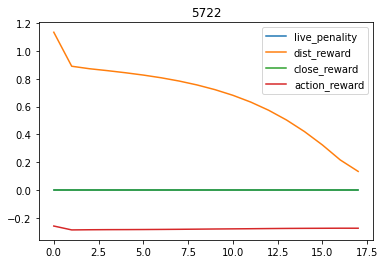

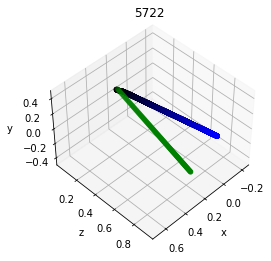

| eval  | E: 167 | S: 5722 | R: 6.9384
| train | E: 168 | S: 5722 | R: -0.7498 | D: 293.6 s | BR: 0.0313 | ALOSS: -10.0368 | CLOSS: 1.9759 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6070
| train | E: 169 | S: 5750 | R: 8.3830 | D: 254.3 s | BR: 0.0375 | ALOSS: -8.7405 | CLOSS: 1.7249 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6286
| train | E: 170 | S: 5779 | R: 9.5915 | D: 197.2 s | BR: 0.0455 | ALOSS: -9.4051 | CLOSS: 1.7899 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6320
| train | E: 171 | S: 5824 | R: 4.9880 | D: 274.0 s | BR: 0.0506 | ALOSS: -9.3216 | CLOSS: 1.3460 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7385
| train | E: 172 | S: 5853 | R: 8.0712 | D: 216.8 s | BR: 0.0322 | ALOSS: -10.1714 | CLOSS: 1.9931 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7619
| train | E: 173 | S: 5897 | R: 4.9256 | D: 256.3 s | BR: 0.0364 | ALOSS: -9.9851 | CLOSS: 1.5213 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6677
| train | E: 174 | S: 5947 | R: -0.2345 | D: 307.5 s | BR: 0.0575 | ALOSS: -9.4591 | CLOSS: 1.

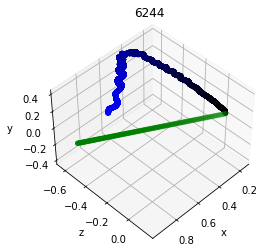

| eval  | E: 181 | S: 6244 | R: 4.5743
| train | E: 182 | S: 6244 | R: 6.6390 | D: 190.7 s | BR: 0.0434 | ALOSS: -9.4542 | CLOSS: 1.3513 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7168
| train | E: 183 | S: 6294 | R: 3.2817 | D: 618.0 s | BR: 0.0363 | ALOSS: -10.6200 | CLOSS: 1.4096 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6528
| train | E: 184 | S: 6344 | R: -1.7254 | D: 314.1 s | BR: 0.0480 | ALOSS: -9.9891 | CLOSS: 2.0768 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6479
| train | E: 185 | S: 6379 | R: 4.7789 | D: 195.0 s | BR: 0.0355 | ALOSS: -9.2889 | CLOSS: 2.0161 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6803
| train | E: 186 | S: 6422 | R: 3.4080 | D: 258.7 s | BR: 0.0405 | ALOSS: -10.0993 | CLOSS: 1.7362 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6855
| train | E: 187 | S: 6450 | R: 8.4662 | D: 174.4 s | BR: 0.0448 | ALOSS: -9.7809 | CLOSS: 2.0113 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.5784
| train | E: 188 | S: 6481 | R: 5.6328 | D: 174.7 s | BR: 0.0592 | ALOSS: -9.6313 | CLOSS: 1.1

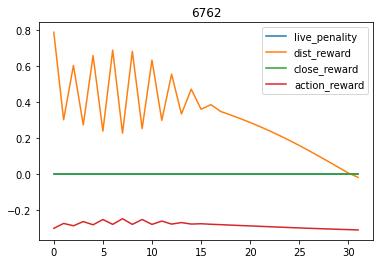

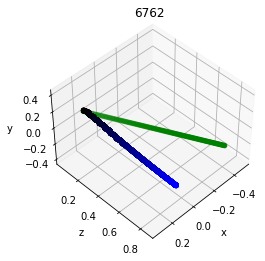

| eval  | E: 196 | S: 6762 | R: 1.3941
| train | E: 197 | S: 6762 | R: 11.3094 | D: 143.7 s | BR: 0.0656 | ALOSS: -9.2952 | CLOSS: 1.5121 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7894
| train | E: 198 | S: 6790 | R: 9.7217 | D: 361.2 s | BR: 0.0266 | ALOSS: -9.6861 | CLOSS: 1.7959 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8243
| train | E: 199 | S: 6812 | R: 11.1592 | D: 118.1 s | BR: 0.0443 | ALOSS: -9.7621 | CLOSS: 1.2905 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8182
| train | E: 200 | S: 6861 | R: 3.1781 | D: 274.0 s | BR: 0.0662 | ALOSS: -9.6824 | CLOSS: 1.7965 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7407
| train | E: 201 | S: 6895 | R: 6.4533 | D: 207.2 s | BR: 0.0637 | ALOSS: -9.4985 | CLOSS: 1.3344 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7097
| train | E: 202 | S: 6916 | R: 8.0747 | D: 130.0 s | BR: 0.0787 | ALOSS: -9.0382 | CLOSS: 1.3836 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6382
| train | E: 203 | S: 6966 | R: 1.2100 | D: 334.9 s | BR: 0.0328 | ALOSS: -9.8371 | CLOSS: 1.69

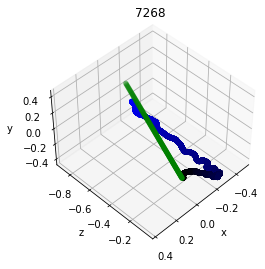

| eval  | E: 212 | S: 7268 | R: 8.7268
| train | E: 213 | S: 7268 | R: 9.7893 | D: 77.4 s | BR: 0.0688 | ALOSS: -9.5916 | CLOSS: 1.0972 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7467
| train | E: 214 | S: 7296 | R: 7.9839 | D: 409.0 s | BR: 0.0667 | ALOSS: -10.1355 | CLOSS: 1.2900 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7135
| train | E: 215 | S: 7331 | R: 5.8911 | D: 187.2 s | BR: 0.0522 | ALOSS: -9.9976 | CLOSS: 1.5625 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7558
| train | E: 216 | S: 7381 | R: -0.7082 | D: 278.0 s | BR: 0.0742 | ALOSS: -9.6921 | CLOSS: 1.6791 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6024
| train | E: 217 | S: 7409 | R: 8.6976 | D: 157.9 s | BR: 0.0607 | ALOSS: -9.4232 | CLOSS: 2.2324 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7179
| train | E: 218 | S: 7459 | R: 0.2651 | D: 281.0 s | BR: 0.0591 | ALOSS: -9.1599 | CLOSS: 1.3200 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6799
| train | E: 219 | S: 7483 | R: 8.8005 | D: 131.8 s | BR: 0.0546 | ALOSS: -9.8370 | CLOSS: 1.277

| eval  | E: 227 | S: 7774 | R: 10.8587
| train | E: 228 | S: 7774 | R: 8.4237 | D: 136.4 s | BR: 0.0630 | ALOSS: -10.0015 | CLOSS: 1.9396 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6881
| train | E: 229 | S: 7824 | R: 1.1567 | D: 458.2 s | BR: 0.0565 | ALOSS: -9.8165 | CLOSS: 2.0067 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6098
| train | E: 230 | S: 7850 | R: 7.8666 | D: 147.8 s | BR: 0.0591 | ALOSS: -10.0056 | CLOSS: 1.2707 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6661
| train | E: 231 | S: 7900 | R: -5.2399 | D: 271.1 s | BR: 0.0569 | ALOSS: -9.7823 | CLOSS: 1.4709 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6834
| train | E: 232 | S: 7918 | R: 7.8214 | D: 100.4 s | BR: 0.0833 | ALOSS: -9.7656 | CLOSS: 2.0728 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7830
| train | E: 233 | S: 7943 | R: 5.4712 | D: 132.5 s | BR: 0.0623 | ALOSS: -9.3745 | CLOSS: 1.9326 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7381
| train | E: 234 | S: 7993 | R: -1.0278 | D: 273.2 s | BR: 0.0655 | ALOSS: -9.2688 | CLOSS: 1

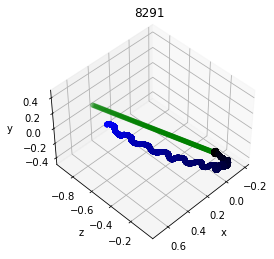

| eval  | E: 243 | S: 8291 | R: 7.9366
| train | E: 244 | S: 8291 | R: 10.2539 | D: 128.5 s | BR: 0.0725 | ALOSS: -9.6020 | CLOSS: 1.0405 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7153
| train | E: 245 | S: 8317 | R: 9.3045 | D: 368.5 s | BR: 0.0741 | ALOSS: -9.8201 | CLOSS: 1.6083 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8019
| train | E: 246 | S: 8352 | R: 6.8500 | D: 197.8 s | BR: 0.0746 | ALOSS: -9.4610 | CLOSS: 1.4878 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7290
| train | E: 247 | S: 8397 | R: 2.3563 | D: 243.9 s | BR: 0.0496 | ALOSS: -9.7047 | CLOSS: 1.3738 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7559
| train | E: 248 | S: 8424 | R: 6.0029 | D: 147.1 s | BR: 0.0803 | ALOSS: -10.1661 | CLOSS: 0.9284 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6980
| train | E: 249 | S: 8457 | R: 8.2335 | D: 174.9 s | BR: 0.0700 | ALOSS: -10.9215 | CLOSS: 1.7366 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6528
| train | E: 250 | S: 8480 | R: -3.6871 | D: 124.5 s | BR: 0.0648 | ALOSS: -9.6490 | CLOSS: 2.

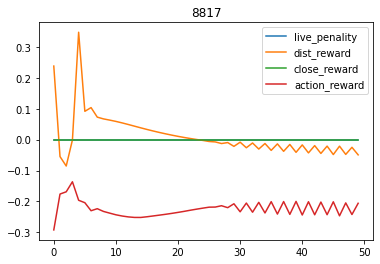

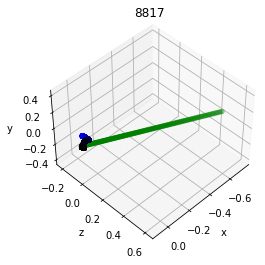

| eval  | E: 259 | S: 8817 | R: -10.6274
| train | E: 260 | S: 8817 | R: 4.5300 | D: 252.5 s | BR: 0.0755 | ALOSS: -9.7279 | CLOSS: 1.7442 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7997
| train | E: 261 | S: 8834 | R: 10.4144 | D: 366.5 s | BR: 0.0802 | ALOSS: -9.8729 | CLOSS: 1.1856 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8515
| train | E: 262 | S: 8884 | R: 2.6854 | D: 272.1 s | BR: 0.0854 | ALOSS: -9.4118 | CLOSS: 1.3498 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7358
| train | E: 263 | S: 8910 | R: -9.8960 | D: 140.8 s | BR: 0.0619 | ALOSS: -8.2768 | CLOSS: 1.1653 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7291
| train | E: 264 | S: 8951 | R: 3.4354 | D: 221.1 s | BR: 0.0929 | ALOSS: -8.8744 | CLOSS: 1.1775 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8114
| train | E: 265 | S: 8983 | R: 7.9847 | D: 172.7 s | BR: 0.0663 | ALOSS: -9.7792 | CLOSS: 1.5684 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7783
| train | E: 266 | S: 8998 | R: 12.5961 | D: 83.7 s | BR: 0.0830 | ALOSS: -9.8970 | CLOSS: 0.

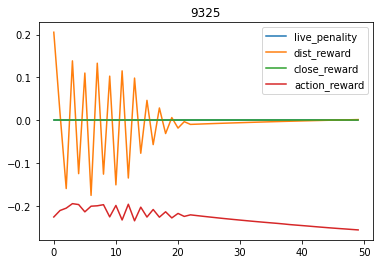

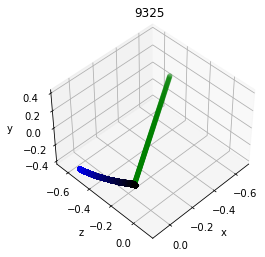

| eval  | E: 274 | S: 9325 | R: -11.5627
| train | E: 275 | S: 9325 | R: 10.5158 | D: 115.9 s | BR: 0.0817 | ALOSS: -8.8029 | CLOSS: 1.3349 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7529
| train | E: 276 | S: 9348 | R: 10.2752 | D: 409.6 s | BR: 0.0548 | ALOSS: -9.1853 | CLOSS: 1.6565 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7039
| train | E: 277 | S: 9377 | R: 8.9177 | D: 164.8 s | BR: 0.0750 | ALOSS: -8.9418 | CLOSS: 1.2725 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6884
| train | E: 278 | S: 9419 | R: 5.5007 | D: 229.4 s | BR: 0.0943 | ALOSS: -9.6147 | CLOSS: 1.4971 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6227
| train | E: 279 | S: 9439 | R: 9.6901 | D: 112.7 s | BR: 0.0825 | ALOSS: -9.7590 | CLOSS: 1.9901 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8114
| train | E: 280 | S: 9469 | R: 7.9114 | D: 163.1 s | BR: 0.0646 | ALOSS: -9.5302 | CLOSS: 1.7046 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6298
| train | E: 281 | S: 9519 | R: -5.6963 | D: 287.6 s | BR: 0.0788 | ALOSS: -8.8003 | CLOSS: 1

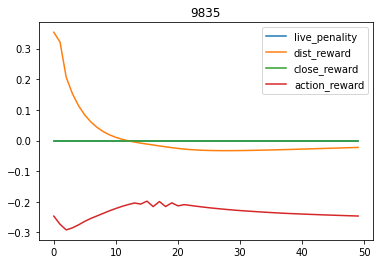

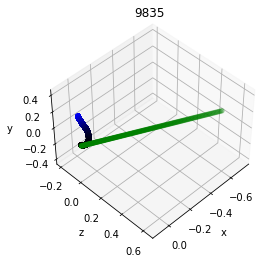

| eval  | E: 291 | S: 9835 | R: -11.2355
| train | E: 292 | S: 9835 | R: 12.0259 | D: 93.3 s | BR: 0.1011 | ALOSS: -9.8198 | CLOSS: 1.5233 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8204
| train | E: 293 | S: 9883 | R: 4.1340 | D: 542.2 s | BR: 0.0652 | ALOSS: -8.6689 | CLOSS: 1.4733 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8058
| train | E: 294 | S: 9910 | R: 9.2311 | D: 143.2 s | BR: 0.0966 | ALOSS: -8.0985 | CLOSS: 1.8158 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6853
| train | E: 295 | S: 9945 | R: 7.7650 | D: 187.2 s | BR: 0.0694 | ALOSS: -8.7365 | CLOSS: 1.1936 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7521
| train | E: 296 | S: 9969 | R: 8.9452 | D: 146.1 s | BR: 0.1004 | ALOSS: -9.6121 | CLOSS: 2.1293 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6672
| train | E: 297 | S: 10007 | R: 4.6192 | D: 204.4 s | BR: 0.0900 | ALOSS: -8.9938 | CLOSS: 2.2332 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6178
| train | E: 298 | S: 10034 | R: 8.8086 | D: 152.7 s | BR: 0.0800 | ALOSS: -9.5513 | CLOSS: 1.

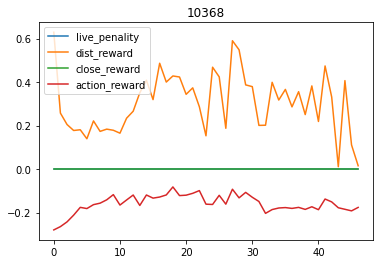

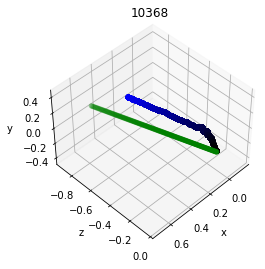

| eval  | E: 306 | S: 10368 | R: 6.8664
| train | E: 307 | S: 10368 | R: 6.3347 | D: 198.9 s | BR: 0.0747 | ALOSS: -9.6492 | CLOSS: 1.4116 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7240
| train | E: 308 | S: 10390 | R: 10.6940 | D: 376.9 s | BR: 0.1082 | ALOSS: -10.1751 | CLOSS: 0.9567 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7578
| train | E: 309 | S: 10418 | R: 9.3288 | D: 151.5 s | BR: 0.0919 | ALOSS: -10.4304 | CLOSS: 1.2685 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6872
| train | E: 310 | S: 10448 | R: 6.9626 | D: 163.1 s | BR: 0.1059 | ALOSS: -10.1475 | CLOSS: 1.0341 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8236
| train | E: 311 | S: 10482 | R: 7.3909 | D: 182.4 s | BR: 0.1076 | ALOSS: -9.2832 | CLOSS: 1.1715 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8087
| train | E: 312 | S: 10506 | R: 10.0633 | D: 136.8 s | BR: 0.1116 | ALOSS: -9.8220 | CLOSS: 1.9037 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7811
| train | E: 313 | S: 10543 | R: 6.4716 | D: 209.7 s | BR: 0.0885 | ALOSS: -9.6288 | 

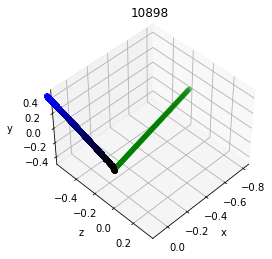

| eval  | E: 323 | S: 10898 | R: -13.2646
| train | E: 324 | S: 10898 | R: 7.7225 | D: 166.1 s | BR: 0.0954 | ALOSS: -11.0244 | CLOSS: 1.5113 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6519
| train | E: 325 | S: 10926 | R: 9.4354 | D: 420.6 s | BR: 0.1040 | ALOSS: -10.7131 | CLOSS: 1.8196 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.5641
| train | E: 326 | S: 10957 | R: 6.1762 | D: 168.7 s | BR: 0.0685 | ALOSS: -10.2797 | CLOSS: 1.4328 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7165
| train | E: 327 | S: 10993 | R: 5.1198 | D: 195.9 s | BR: 0.1092 | ALOSS: -9.8910 | CLOSS: 1.7525 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7505
| train | E: 328 | S: 11026 | R: 6.7031 | D: 179.0 s | BR: 0.0910 | ALOSS: -9.1293 | CLOSS: 1.2648 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8063
| train | E: 329 | S: 11076 | R: 2.7771 | D: 270.4 s | BR: 0.0953 | ALOSS: -9.5060 | CLOSS: 1.4616 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8831
| train | E: 330 | S: 11107 | R: 7.7627 | D: 164.0 s | BR: 0.0941 | ALOSS: -9.2460 | 

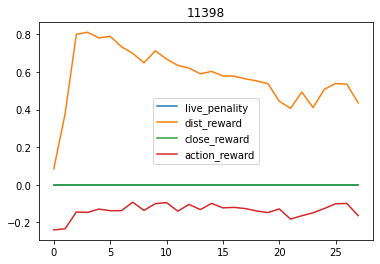

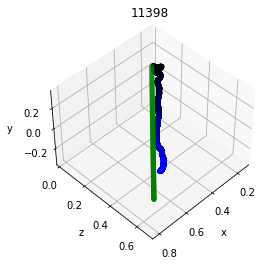

| eval  | E: 338 | S: 11398 | R: 12.2706
| train | E: 339 | S: 11398 | R: 4.8342 | D: 107.1 s | BR: 0.1097 | ALOSS: -11.2750 | CLOSS: 2.8587 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6755
| train | E: 340 | S: 11414 | R: 11.2960 | D: 245.9 s | BR: 0.1072 | ALOSS: -9.6813 | CLOSS: 1.1589 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7005
| train | E: 341 | S: 11450 | R: 5.9436 | D: 195.0 s | BR: 0.0927 | ALOSS: -9.3315 | CLOSS: 1.4321 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8097
| train | E: 342 | S: 11480 | R: 8.1419 | D: 168.5 s | BR: 0.0858 | ALOSS: -10.0312 | CLOSS: 1.3907 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6907
| train | E: 343 | S: 11522 | R: 4.5332 | D: 226.9 s | BR: 0.1047 | ALOSS: -10.1478 | CLOSS: 1.3870 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7328
| train | E: 344 | S: 11540 | R: 11.9368 | D: 103.4 s | BR: 0.0784 | ALOSS: -9.3251 | CLOSS: 1.8816 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7498
| train | E: 345 | S: 11574 | R: -13.9877 | D: 192.1 s | BR: 0.1024 | ALOSS: -9.3901

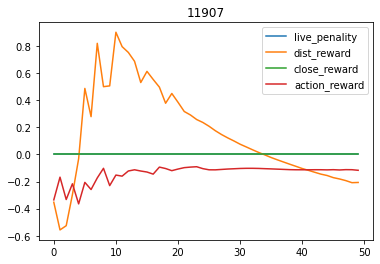

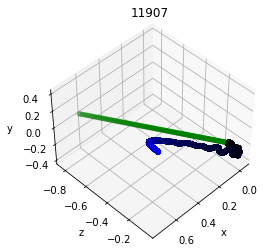

| eval  | E: 353 | S: 11907 | R: 0.6243
| train | E: 354 | S: 11907 | R: 1.4220 | D: 288.5 s | BR: 0.1004 | ALOSS: -9.9708 | CLOSS: 1.3414 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7603
| train | E: 355 | S: 11957 | R: -1.9329 | D: 561.1 s | BR: 0.1062 | ALOSS: -9.7176 | CLOSS: 1.6781 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7643
| train | E: 356 | S: 11994 | R: 5.1105 | D: 199.0 s | BR: 0.0916 | ALOSS: -9.7888 | CLOSS: 1.2031 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7149
| train | E: 357 | S: 12033 | R: 1.4248 | D: 208.1 s | BR: 0.0929 | ALOSS: -10.0912 | CLOSS: 1.3862 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7164
| train | E: 358 | S: 12051 | R: 10.8603 | D: 95.2 s | BR: 0.1031 | ALOSS: -8.9501 | CLOSS: 1.5274 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6900
| train | E: 359 | S: 12082 | R: 8.5508 | D: 174.2 s | BR: 0.0797 | ALOSS: -9.1293 | CLOSS: 1.4408 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7088
| train | E: 360 | S: 12109 | R: 3.2941 | D: 143.1 s | BR: 0.0902 | ALOSS: -10.1477 | CL

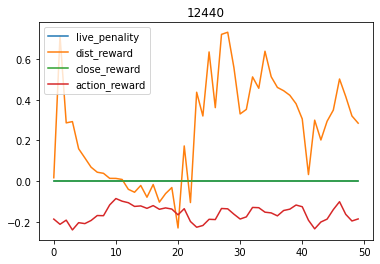

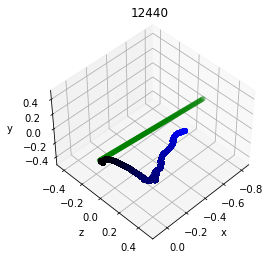

| eval  | E: 371 | S: 12440 | R: 4.3987
| train | E: 372 | S: 12440 | R: 7.5304 | D: 186.1 s | BR: 0.0979 | ALOSS: -9.2689 | CLOSS: 1.2736 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6849
| train | E: 373 | S: 12477 | R: 6.0716 | D: 486.9 s | BR: 0.1333 | ALOSS: -10.4376 | CLOSS: 1.1734 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7490
| train | E: 374 | S: 12517 | R: 6.0604 | D: 224.6 s | BR: 0.1081 | ALOSS: -10.9612 | CLOSS: 1.2994 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6852
| train | E: 375 | S: 12567 | R: 1.1656 | D: 270.9 s | BR: 0.1038 | ALOSS: -9.5627 | CLOSS: 1.2207 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7779
| train | E: 376 | S: 12617 | R: -0.3464 | D: 288.8 s | BR: 0.0951 | ALOSS: -9.6185 | CLOSS: 1.2850 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8453
| train | E: 377 | S: 12667 | R: 1.5207 | D: 272.6 s | BR: 0.1039 | ALOSS: -9.7865 | CLOSS: 1.5541 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7885
| train | E: 378 | S: 12711 | R: 4.1695 | D: 249.1 s | BR: 0.1000 | ALOSS: -9.0075 | CL

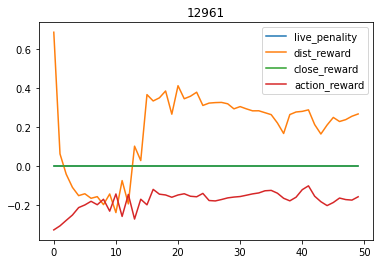

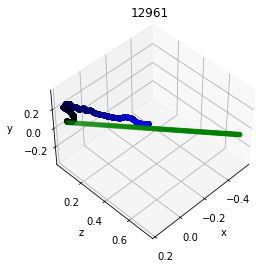

| eval  | E: 383 | S: 12961 | R: 0.4554
| train | E: 384 | S: 12961 | R: 3.9128 | D: 262.5 s | BR: 0.0955 | ALOSS: -10.0006 | CLOSS: 1.8532 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7017
| train | E: 385 | S: 12977 | R: -0.5614 | D: 359.6 s | BR: 0.1083 | ALOSS: -9.7548 | CLOSS: 1.1697 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7413
| train | E: 386 | S: 13000 | R: 9.5096 | D: 122.2 s | BR: 0.1047 | ALOSS: -9.7713 | CLOSS: 1.8534 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7913
| train | E: 387 | S: 13048 | R: 3.5975 | D: 274.1 s | BR: 0.1003 | ALOSS: -9.4174 | CLOSS: 1.5757 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7886
| train | E: 388 | S: 13084 | R: 6.1850 | D: 195.5 s | BR: 0.1103 | ALOSS: -9.5939 | CLOSS: 1.4771 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7521
| train | E: 389 | S: 13104 | R: 11.3891 | D: 115.2 s | BR: 0.0909 | ALOSS: -9.7982 | CLOSS: 1.2049 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7034
| train | E: 390 | S: 13146 | R: 5.6535 | D: 229.3 s | BR: 0.1081 | ALOSS: -9.7210 | CL

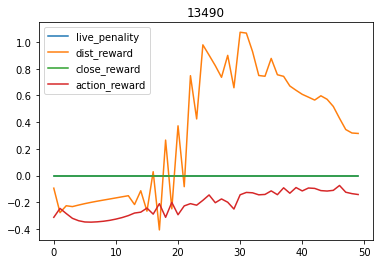

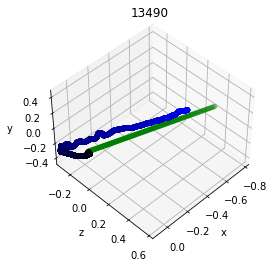

| eval  | E: 400 | S: 13490 | R: 5.7059
| train | E: 401 | S: 13490 | R: 6.8002 | D: 208.9 s | BR: 0.0893 | ALOSS: -12.1423 | CLOSS: 1.2842 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7310
| train | E: 402 | S: 13531 | R: 4.4708 | D: 521.1 s | BR: 0.1158 | ALOSS: -10.5686 | CLOSS: 1.6901 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6351
| train | E: 403 | S: 13573 | R: 4.1801 | D: 233.5 s | BR: 0.1054 | ALOSS: -9.4548 | CLOSS: 1.1033 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8153
| train | E: 404 | S: 13617 | R: 4.9772 | D: 239.6 s | BR: 0.1105 | ALOSS: -9.5150 | CLOSS: 1.4348 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8244
| train | E: 405 | S: 13667 | R: -8.1860 | D: 276.5 s | BR: 0.1047 | ALOSS: -9.6537 | CLOSS: 1.2835 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7823
| train | E: 406 | S: 13685 | R: 9.3693 | D: 98.1 s | BR: 0.1347 | ALOSS: -10.0235 | CLOSS: 1.1536 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8287
| train | E: 407 | S: 13709 | R: 9.4117 | D: 132.3 s | BR: 0.1214 | ALOSS: -10.0283 | C

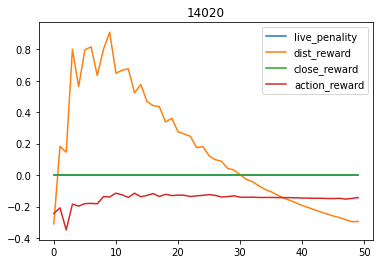

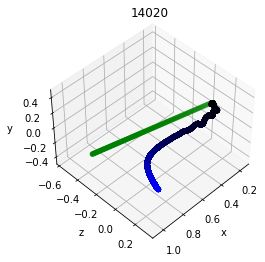

| eval  | E: 415 | S: 14020 | R: 1.0871
| train | E: 416 | S: 14020 | R: 7.2255 | D: 201.5 s | BR: 0.1205 | ALOSS: -10.3889 | CLOSS: 1.2272 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8476
| train | E: 417 | S: 14036 | R: 12.2681 | D: 380.2 s | BR: 0.1081 | ALOSS: -10.1434 | CLOSS: 1.0991 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8663
| train | E: 418 | S: 14085 | R: 3.9580 | D: 270.4 s | BR: 0.1352 | ALOSS: -9.2308 | CLOSS: 1.3954 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8465
| train | E: 419 | S: 14113 | R: 8.0911 | D: 153.5 s | BR: 0.0894 | ALOSS: -10.0065 | CLOSS: 0.7524 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8483
| train | E: 420 | S: 14139 | R: 9.1906 | D: 141.0 s | BR: 0.0873 | ALOSS: -10.2103 | CLOSS: 1.1566 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9406
| train | E: 421 | S: 14166 | R: 8.8512 | D: 157.0 s | BR: 0.0963 | ALOSS: -10.8935 | CLOSS: 1.4022 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7738
NAN OBS
bad observation, try new traj
| train | E: 422 | S: 14185 | R: 12.0880 | D: 

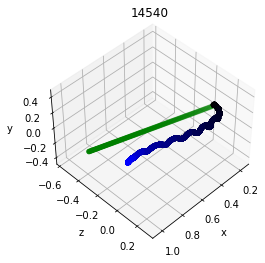

| eval  | E: 431 | S: 14540 | R: 8.7231
| train | E: 432 | S: 14540 | R: 8.8696 | D: 173.8 s | BR: 0.1131 | ALOSS: -11.2888 | CLOSS: 2.0771 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7511
| train | E: 433 | S: 14575 | R: 7.2751 | D: 411.0 s | BR: 0.1186 | ALOSS: -10.5113 | CLOSS: 1.3948 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8225
| train | E: 434 | S: 14599 | R: 9.9263 | D: 130.2 s | BR: 0.1059 | ALOSS: -10.1740 | CLOSS: 1.9909 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.6926
| train | E: 435 | S: 14620 | R: 10.6670 | D: 129.4 s | BR: 0.0968 | ALOSS: -9.5428 | CLOSS: 0.9362 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.7359
NAN OBS
bad observation, try new traj
| train | E: 436 | S: 14670 | R: 0.4857 | D: 450.4 s | BR: 0.1153 | ALOSS: -9.8158 | CLOSS: 1.3602 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8569
| train | E: 437 | S: 14703 | R: 6.6579 | D: 184.3 s | BR: 0.1384 | ALOSS: -10.1433 | CLOSS: 0.8692 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9300
NAN OBS
bad observation, try new traj
| train |

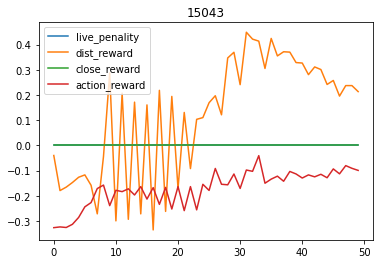

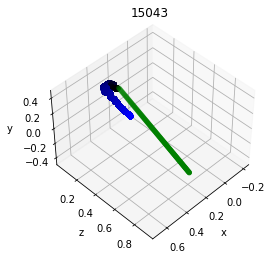

| eval  | E: 445 | S: 15043 | R: -2.4149
| train | E: 446 | S: 15043 | R: 0.5038 | D: 281.7 s | BR: 0.1068 | ALOSS: -9.8240 | CLOSS: 1.2168 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0032
| train | E: 447 | S: 15064 | R: 10.5546 | D: 399.7 s | BR: 0.1268 | ALOSS: -10.3847 | CLOSS: 0.9978 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9870
| train | E: 448 | S: 15103 | R: 6.3923 | D: 219.9 s | BR: 0.0984 | ALOSS: -10.7028 | CLOSS: 1.1773 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9586
| train | E: 449 | S: 15151 | R: 3.9764 | D: 278.6 s | BR: 0.1130 | ALOSS: -9.8957 | CLOSS: 1.2899 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9671
| train | E: 450 | S: 15167 | R: 11.3889 | D: 86.8 s | BR: 0.1218 | ALOSS: -9.7210 | CLOSS: 0.9477 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0353
| train | E: 451 | S: 15211 | R: 3.1950 | D: 255.4 s | BR: 0.1194 | ALOSS: -10.0980 | CLOSS: 1.1428 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0249
| train | E: 452 | S: 15225 | R: 13.4381 | D: 76.7 s | BR: 0.1251 | ALOSS: -10.2224 |

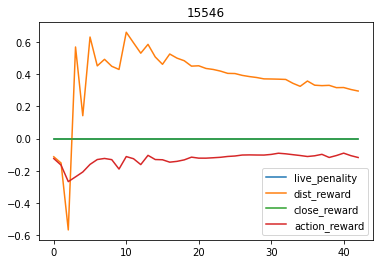

| eval  | E: 460 | S: 15546 | R: 10.5411
| train | E: 461 | S: 15546 | R: 3.3442 | D: 278.8 s | BR: 0.1315 | ALOSS: -9.7858 | CLOSS: 1.1978 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9434
| train | E: 462 | S: 15566 | R: 10.4576 | D: 364.7 s | BR: 0.1119 | ALOSS: -10.3892 | CLOSS: 1.0562 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9474
| train | E: 463 | S: 15614 | R: 0.0736 | D: 272.1 s | BR: 0.1225 | ALOSS: -10.3610 | CLOSS: 0.8665 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9460
| train | E: 464 | S: 15647 | R: 7.4392 | D: 188.1 s | BR: 0.1139 | ALOSS: -10.1327 | CLOSS: 1.2161 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9864
| train | E: 465 | S: 15665 | R: 10.7644 | D: 104.0 s | BR: 0.1382 | ALOSS: -10.6783 | CLOSS: 0.7010 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9788
| train | E: 466 | S: 15690 | R: 11.5316 | D: 139.5 s | BR: 0.1148 | ALOSS: -11.5056 | CLOSS: 1.1605 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9962
| train | E: 467 | S: 15709 | R: 9.9966 | D: 112.8 s | BR: 0.1203 | ALOSS: -11.73

| eval  | E: 477 | S: 16093 | R: -3.4336
| train | E: 478 | S: 16093 | R: 3.0389 | D: 301.9 s | BR: 0.1201 | ALOSS: -8.7557 | CLOSS: 1.3361 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9894
| train | E: 479 | S: 16130 | R: 6.6372 | D: 498.6 s | BR: 0.1324 | ALOSS: -10.4005 | CLOSS: 1.2340 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9863
| train | E: 480 | S: 16180 | R: 1.1187 | D: 298.6 s | BR: 0.1193 | ALOSS: -10.0127 | CLOSS: 1.0964 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9228
| train | E: 481 | S: 16221 | R: 4.8457 | D: 237.8 s | BR: 0.1265 | ALOSS: -10.0786 | CLOSS: 1.3255 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9385
| train | E: 482 | S: 16271 | R: 0.2229 | D: 282.9 s | BR: 0.1403 | ALOSS: -9.8869 | CLOSS: 1.1151 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8751
| train | E: 483 | S: 16302 | R: 7.8632 | D: 174.1 s | BR: 0.0915 | ALOSS: -10.2427 | CLOSS: 0.9151 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9352
| train | E: 484 | S: 16320 | R: 11.9154 | D: 103.0 s | BR: 0.0947 | ALOSS: -10.0576 

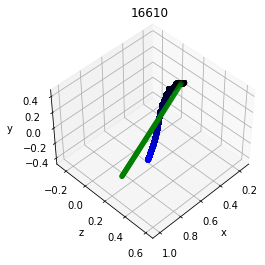

| eval  | E: 492 | S: 16610 | R: 9.3334
| train | E: 493 | S: 16610 | R: 7.4580 | D: 174.7 s | BR: 0.1129 | ALOSS: -9.9086 | CLOSS: 0.9651 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8985
| train | E: 494 | S: 16650 | R: 5.6972 | D: 505.3 s | BR: 0.1273 | ALOSS: -9.9016 | CLOSS: 1.0873 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9786
| train | E: 495 | S: 16692 | R: 4.6112 | D: 236.3 s | BR: 0.1296 | ALOSS: -9.2707 | CLOSS: 1.5895 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9488
| train | E: 496 | S: 16713 | R: 10.6383 | D: 116.6 s | BR: 0.1415 | ALOSS: -9.8415 | CLOSS: 1.0323 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0017
| train | E: 497 | S: 16743 | R: 8.3483 | D: 166.7 s | BR: 0.1231 | ALOSS: -11.0534 | CLOSS: 1.5059 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9754
| train | E: 498 | S: 16778 | R: -2.1595 | D: 194.9 s | BR: 0.0973 | ALOSS: -10.5616 | CLOSS: 1.1416 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9426
| train | E: 499 | S: 16801 | R: 10.0408 | D: 126.4 s | BR: 0.1229 | ALOSS: -10.0728 |

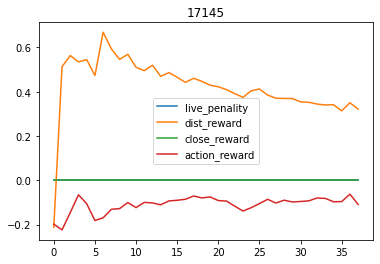

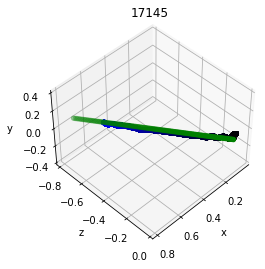

| eval  | E: 507 | S: 17145 | R: 12.0056
| train | E: 508 | S: 17145 | R: 5.2667 | D: 240.1 s | BR: 0.1106 | ALOSS: -10.1788 | CLOSS: 1.0016 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9431
| train | E: 509 | S: 17195 | R: -10.5377 | D: 513.7 s | BR: 0.1370 | ALOSS: -11.2162 | CLOSS: 1.2923 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8629
| train | E: 510 | S: 17218 | R: 9.6311 | D: 129.7 s | BR: 0.1473 | ALOSS: -10.3436 | CLOSS: 0.7998 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9366
| train | E: 511 | S: 17251 | R: 6.6819 | D: 186.5 s | BR: 0.1442 | ALOSS: -10.9935 | CLOSS: 0.8438 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9098
| train | E: 512 | S: 17282 | R: 8.3946 | D: 172.0 s | BR: 0.1415 | ALOSS: -10.8562 | CLOSS: 0.9064 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9755
| train | E: 513 | S: 17310 | R: 8.5236 | D: 158.3 s | BR: 0.1139 | ALOSS: -10.4997 | CLOSS: 1.0771 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0091
| train | E: 514 | S: 17351 | R: -2.7348 | D: 229.3 s | BR: 0.1242 | ALOSS: -10.1

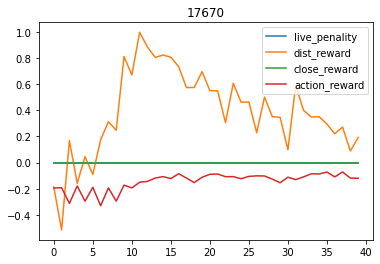

| eval  | E: 522 | S: 17670 | R: 9.7684
| train | E: 523 | S: 17670 | R: 10.1879 | D: 142.1 s | BR: 0.1247 | ALOSS: -10.4578 | CLOSS: 1.2590 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9616
| train | E: 524 | S: 17690 | R: 10.7420 | D: 348.5 s | BR: 0.1323 | ALOSS: -10.2387 | CLOSS: 2.8819 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9482
| train | E: 525 | S: 17715 | R: 10.6321 | D: 135.9 s | BR: 0.1198 | ALOSS: -9.8109 | CLOSS: 0.8196 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9747
| train | E: 526 | S: 17737 | R: 10.6598 | D: 121.1 s | BR: 0.1300 | ALOSS: -9.7393 | CLOSS: 0.8520 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0612
| train | E: 527 | S: 17787 | R: -2.2355 | D: 299.0 s | BR: 0.1249 | ALOSS: -10.0493 | CLOSS: 1.2031 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0611
| train | E: 528 | S: 17808 | R: 10.7527 | D: 115.2 s | BR: 0.1404 | ALOSS: -9.8201 | CLOSS: 2.1535 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9759
| train | E: 529 | S: 17858 | R: -8.6853 | D: 296.9 s | BR: 0.1253 | ALOSS: -10.2

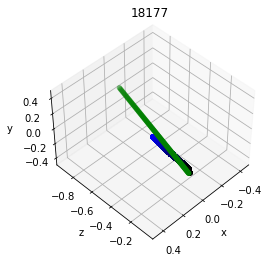

| eval  | E: 537 | S: 18177 | R: 0.7418
| train | E: 538 | S: 18177 | R: -0.9335 | D: 298.1 s | BR: 0.1084 | ALOSS: -10.0354 | CLOSS: 1.2791 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9725
| train | E: 539 | S: 18220 | R: 3.0366 | D: 519.2 s | BR: 0.1193 | ALOSS: -10.2559 | CLOSS: 1.0801 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0057
| train | E: 540 | S: 18265 | R: 3.7238 | D: 262.9 s | BR: 0.1458 | ALOSS: -9.9551 | CLOSS: 0.7745 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0401
| train | E: 541 | S: 18289 | R: 9.8409 | D: 134.5 s | BR: 0.1231 | ALOSS: -10.7157 | CLOSS: 1.0970 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0335
| train | E: 542 | S: 18338 | R: 3.6899 | D: 281.3 s | BR: 0.1269 | ALOSS: -10.1497 | CLOSS: 1.3271 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9295
| train | E: 543 | S: 18365 | R: 8.6092 | D: 155.9 s | BR: 0.1231 | ALOSS: -10.1268 | CLOSS: 1.2113 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9594
| train | E: 544 | S: 18406 | R: 6.2555 | D: 235.5 s | BR: 0.1366 | ALOSS: -10.9360 

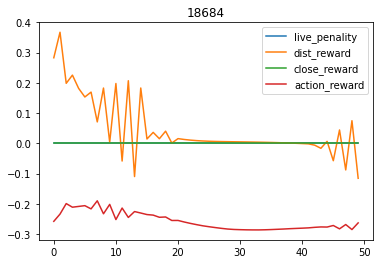

| eval  | E: 551 | S: 18684 | R: -10.5537
| train | E: 552 | S: 18684 | R: 3.8940 | D: 257.7 s | BR: 0.1367 | ALOSS: -10.3243 | CLOSS: 1.2846 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9773
| train | E: 553 | S: 18722 | R: 6.5694 | D: 484.7 s | BR: 0.1203 | ALOSS: -10.2808 | CLOSS: 0.9230 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9367
| train | E: 554 | S: 18748 | R: 9.4221 | D: 148.0 s | BR: 0.1077 | ALOSS: -9.9268 | CLOSS: 0.6970 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9721
| train | E: 555 | S: 18772 | R: 4.9004 | D: 134.0 s | BR: 0.1314 | ALOSS: -10.2007 | CLOSS: 1.4716 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0209
| train | E: 556 | S: 18799 | R: 8.6864 | D: 156.8 s | BR: 0.1472 | ALOSS: -10.1252 | CLOSS: 1.1768 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0868
| train | E: 557 | S: 18824 | R: 9.5663 | D: 139.4 s | BR: 0.1316 | ALOSS: -9.9696 | CLOSS: 0.7724 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9933
| train | E: 558 | S: 18865 | R: 5.6253 | D: 246.4 s | BR: 0.1129 | ALOSS: -10.2241 

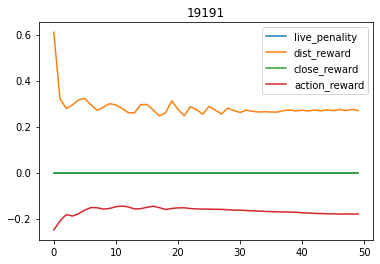

| eval  | E: 568 | S: 19191 | R: 5.7664
| train | E: 569 | S: 19191 | R: -4.8201 | D: 306.2 s | BR: 0.1077 | ALOSS: -10.7871 | CLOSS: 0.8989 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9616
| train | E: 570 | S: 19235 | R: 1.8470 | D: 530.3 s | BR: 0.1223 | ALOSS: -10.8656 | CLOSS: 1.1457 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8865
| train | E: 571 | S: 19259 | R: 9.4773 | D: 135.9 s | BR: 0.1072 | ALOSS: -10.4759 | CLOSS: 1.8163 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9395
| train | E: 572 | S: 19279 | R: 9.9892 | D: 113.0 s | BR: 0.1155 | ALOSS: -9.6229 | CLOSS: 0.7799 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0083
| train | E: 573 | S: 19320 | R: 4.6003 | D: 226.1 s | BR: 0.1465 | ALOSS: -10.2086 | CLOSS: 0.8351 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0778
| train | E: 574 | S: 19355 | R: -6.0589 | D: 199.7 s | BR: 0.1304 | ALOSS: -10.8236 | CLOSS: 1.2948 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0682
| train | E: 575 | S: 19378 | R: 10.0699 | D: 128.9 s | BR: 0.1170 | ALOSS: -10.207

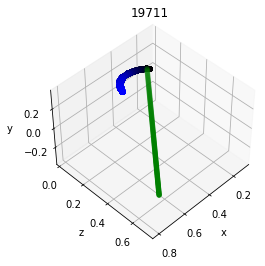

| eval  | E: 584 | S: 19711 | R: -5.8261
| train | E: 585 | S: 19711 | R: 8.6456 | D: 163.3 s | BR: 0.1393 | ALOSS: -9.8835 | CLOSS: 1.4031 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9812
| train | E: 586 | S: 19735 | R: 9.1930 | D: 407.4 s | BR: 0.1471 | ALOSS: -9.4646 | CLOSS: 1.0448 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9781
| train | E: 587 | S: 19765 | R: 8.2386 | D: 164.8 s | BR: 0.1224 | ALOSS: -10.2009 | CLOSS: 1.1158 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0352
| train | E: 588 | S: 19815 | R: 3.1463 | D: 276.8 s | BR: 0.1387 | ALOSS: -10.9152 | CLOSS: 0.8815 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9747
| train | E: 589 | S: 19838 | R: -10.1191 | D: 134.7 s | BR: 0.1352 | ALOSS: -10.6305 | CLOSS: 2.0928 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9924
| train | E: 590 | S: 19888 | R: -0.7462 | D: 274.1 s | BR: 0.1281 | ALOSS: -10.2376 | CLOSS: 0.9271 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0176
| train | E: 591 | S: 19938 | R: -3.1944 | D: 276.3 s | BR: 0.1304 | ALOSS: -10.68

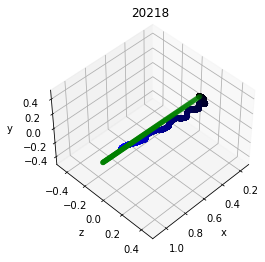

| eval  | E: 597 | S: 20218 | R: 11.0158
| train | E: 598 | S: 20218 | R: 9.0742 | D: 151.7 s | BR: 0.1251 | ALOSS: -10.3042 | CLOSS: 0.9535 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9512
| train | E: 599 | S: 20244 | R: 8.6790 | D: 334.8 s | BR: 0.1132 | ALOSS: -10.8103 | CLOSS: 0.9782 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0375
| train | E: 600 | S: 20264 | R: 10.0753 | D: 107.5 s | BR: 0.1186 | ALOSS: -10.0116 | CLOSS: 1.1268 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0733
| train | E: 601 | S: 20296 | R: 7.4601 | D: 182.8 s | BR: 0.1500 | ALOSS: -9.8612 | CLOSS: 0.8937 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1127
| train | E: 602 | S: 20321 | R: 7.5667 | D: 136.7 s | BR: 0.1339 | ALOSS: -9.9595 | CLOSS: 1.3049 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1165
| train | E: 603 | S: 20342 | R: 5.8484 | D: 122.6 s | BR: 0.1346 | ALOSS: -9.8212 | CLOSS: 1.3009 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0749
| train | E: 604 | S: 20376 | R: 8.2379 | D: 180.5 s | BR: 0.1456 | ALOSS: -10.1774 |

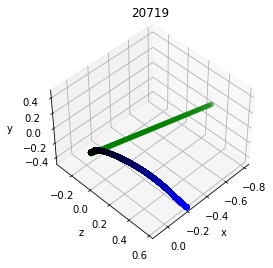

| eval  | E: 614 | S: 20719 | R: -11.9797
| train | E: 615 | S: 20719 | R: 6.3669 | D: 181.2 s | BR: 0.1330 | ALOSS: -10.6335 | CLOSS: 1.0811 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0788
| train | E: 616 | S: 20769 | R: -4.0257 | D: 559.7 s | BR: 0.1259 | ALOSS: -10.6620 | CLOSS: 1.0486 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1005
| train | E: 617 | S: 20801 | R: 5.1029 | D: 172.6 s | BR: 0.1271 | ALOSS: -10.6409 | CLOSS: 1.7037 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1064
| train | E: 618 | S: 20837 | R: 6.9134 | D: 203.3 s | BR: 0.1111 | ALOSS: -9.9084 | CLOSS: 1.3300 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0185
NAN OBS
bad observation, try new traj
| train | E: 619 | S: 20884 | R: 3.4948 | D: 454.6 s | BR: 0.1343 | ALOSS: -10.1980 | CLOSS: 1.3359 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9961
| train | E: 620 | S: 20920 | R: 7.8176 | D: 198.1 s | BR: 0.1170 | ALOSS: -10.6139 | CLOSS: 0.9867 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9289
| train | E: 621 | S: 20948 | R: 6.1067 | D:

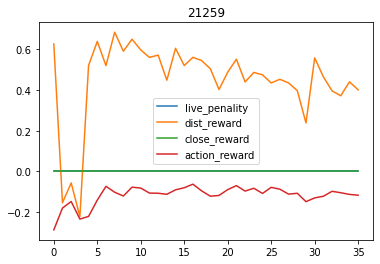

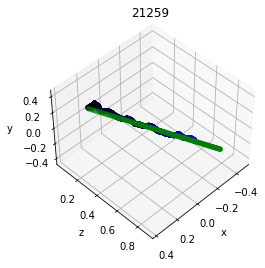

| eval  | E: 629 | S: 21259 | R: 11.9152
| train | E: 630 | S: 21259 | R: 2.8599 | D: 249.1 s | BR: 0.1298 | ALOSS: -10.0656 | CLOSS: 1.0404 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9277
| train | E: 631 | S: 21281 | R: 11.4571 | D: 316.6 s | BR: 0.1459 | ALOSS: -11.2153 | CLOSS: 0.9550 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8726
| train | E: 632 | S: 21303 | R: -2.3826 | D: 118.7 s | BR: 0.1445 | ALOSS: -10.3836 | CLOSS: 1.7330 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9496
| train | E: 633 | S: 21345 | R: 4.0713 | D: 225.7 s | BR: 0.1419 | ALOSS: -10.0793 | CLOSS: 1.2708 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8534
| train | E: 634 | S: 21364 | R: 10.7492 | D: 104.6 s | BR: 0.1135 | ALOSS: -9.9548 | CLOSS: 0.8448 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1415
| train | E: 635 | S: 21404 | R: 6.7890 | D: 212.4 s | BR: 0.1258 | ALOSS: -9.7121 | CLOSS: 0.9071 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0403
| train | E: 636 | S: 21426 | R: 1.2963 | D: 121.0 s | BR: 0.1265 | ALOSS: -10.082

| eval  | E: 648 | S: 21760 | R: 7.6184
| train | E: 649 | S: 21760 | R: 11.2919 | D: 98.0 s | BR: 0.1561 | ALOSS: -10.9164 | CLOSS: 2.2242 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0054
| train | E: 650 | S: 21782 | R: 3.6366 | D: 340.7 s | BR: 0.1238 | ALOSS: -9.8498 | CLOSS: 0.8538 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9377
| train | E: 651 | S: 21817 | R: 6.9694 | D: 195.9 s | BR: 0.1218 | ALOSS: -10.0887 | CLOSS: 1.2877 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9633
| train | E: 652 | S: 21846 | R: 9.1879 | D: 165.6 s | BR: 0.1418 | ALOSS: -9.9952 | CLOSS: 1.4382 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0147
| train | E: 653 | S: 21871 | R: 8.9740 | D: 140.3 s | BR: 0.1197 | ALOSS: -9.8796 | CLOSS: 1.8861 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0399
| train | E: 654 | S: 21895 | R: -0.5596 | D: 128.0 s | BR: 0.1626 | ALOSS: -9.9305 | CLOSS: 1.2771 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0495
| train | E: 655 | S: 21915 | R: 9.7256 | D: 115.9 s | BR: 0.1031 | ALOSS: -9.9818 | CL

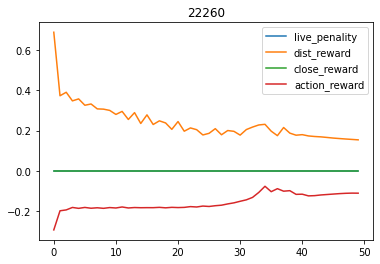

| eval  | E: 665 | S: 22260 | R: 4.1840
| train | E: 666 | S: 22260 | R: 5.8863 | D: 218.0 s | BR: 0.1153 | ALOSS: -10.4281 | CLOSS: 1.1647 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0156
| train | E: 667 | S: 22280 | R: 10.6575 | D: 380.1 s | BR: 0.1298 | ALOSS: -9.8883 | CLOSS: 1.3401 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0963
| train | E: 668 | S: 22296 | R: 12.6682 | D: 88.2 s | BR: 0.1373 | ALOSS: -9.7030 | CLOSS: 1.5481 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0769
| train | E: 669 | S: 22318 | R: 10.0322 | D: 117.4 s | BR: 0.1597 | ALOSS: -9.7417 | CLOSS: 0.7335 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0759
| train | E: 670 | S: 22357 | R: 6.8724 | D: 212.0 s | BR: 0.1416 | ALOSS: -10.3858 | CLOSS: 1.3358 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0454
| train | E: 671 | S: 22379 | R: 9.3096 | D: 120.8 s | BR: 0.1567 | ALOSS: -10.3517 | CLOSS: 1.2649 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0259
| train | E: 672 | S: 22409 | R: 8.0823 | D: 170.5 s | BR: 0.1334 | ALOSS: -9.8949 | 

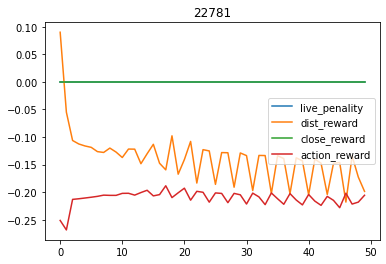

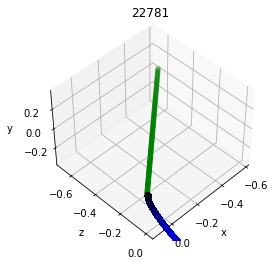

| eval  | E: 684 | S: 22781 | R: -17.5154
| train | E: 685 | S: 22781 | R: -0.6171 | D: 292.3 s | BR: 0.1442 | ALOSS: -9.8763 | CLOSS: 1.0808 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0735
| train | E: 686 | S: 22812 | R: 8.0746 | D: 450.8 s | BR: 0.1649 | ALOSS: -10.9489 | CLOSS: 1.0776 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0553
| train | E: 687 | S: 22841 | R: 8.9991 | D: 154.7 s | BR: 0.1474 | ALOSS: -10.6427 | CLOSS: 1.1903 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0773
| train | E: 688 | S: 22875 | R: 8.2933 | D: 189.8 s | BR: 0.1289 | ALOSS: -10.6654 | CLOSS: 1.1408 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0113
| train | E: 689 | S: 22915 | R: 6.4278 | D: 219.1 s | BR: 0.1322 | ALOSS: -10.4500 | CLOSS: 1.1912 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9983
| train | E: 690 | S: 22937 | R: 10.2483 | D: 123.0 s | BR: 0.1381 | ALOSS: -9.8544 | CLOSS: 1.6128 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.8635
| train | E: 691 | S: 22958 | R: 6.1145 | D: 111.0 s | BR: 0.1232 | ALOSS: -9.2501

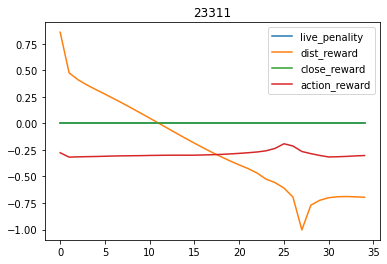

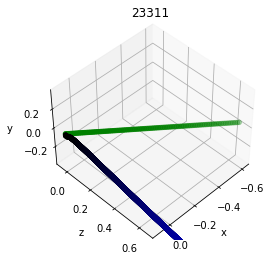

| eval  | E: 702 | S: 23311 | R: -18.0247
| train | E: 703 | S: 23311 | R: 7.2543 | D: 188.0 s | BR: 0.1185 | ALOSS: -10.0932 | CLOSS: 0.9211 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0175
| train | E: 704 | S: 23339 | R: 10.2179 | D: 344.5 s | BR: 0.1219 | ALOSS: -9.5887 | CLOSS: 1.1198 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0287
| train | E: 705 | S: 23378 | R: 5.5294 | D: 212.5 s | BR: 0.1307 | ALOSS: -10.3012 | CLOSS: 0.9989 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0613
| train | E: 706 | S: 23412 | R: 7.3649 | D: 189.8 s | BR: 0.1562 | ALOSS: -10.8604 | CLOSS: 0.9728 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0663
| train | E: 707 | S: 23449 | R: 6.6486 | D: 194.7 s | BR: 0.1353 | ALOSS: -9.9186 | CLOSS: 1.2775 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1031
| train | E: 708 | S: 23477 | R: 8.3684 | D: 160.8 s | BR: 0.1347 | ALOSS: -10.0662 | CLOSS: 0.8994 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1096
| train | E: 709 | S: 23509 | R: 7.1471 | D: 172.6 s | BR: 0.1689 | ALOSS: -10.8084

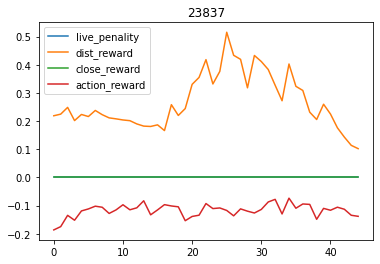

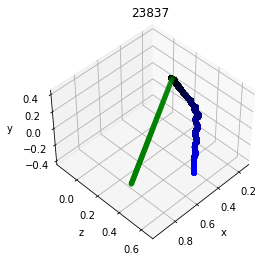

| eval  | E: 717 | S: 23837 | R: 6.7751
| train | E: 718 | S: 23837 | R: -1.8710 | D: 285.8 s | BR: 0.1662 | ALOSS: -10.1678 | CLOSS: 0.8618 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0795
| train | E: 719 | S: 23887 | R: -14.5251 | D: 523.2 s | BR: 0.1468 | ALOSS: -10.8590 | CLOSS: 0.9470 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1649
| train | E: 720 | S: 23911 | R: 9.1383 | D: 126.8 s | BR: 0.1391 | ALOSS: -10.9378 | CLOSS: 1.0704 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0898
| train | E: 721 | S: 23955 | R: 5.2219 | D: 246.0 s | BR: 0.1371 | ALOSS: -10.0229 | CLOSS: 0.7421 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0908
NAN OBS
bad observation, try new traj
| train | E: 722 | S: 24005 | R: -1.0366 | D: 492.3 s | BR: 0.1401 | ALOSS: -10.4220 | CLOSS: 1.2390 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1358
| train | E: 723 | S: 24022 | R: 11.7205 | D: 90.8 s | BR: 0.1667 | ALOSS: -10.1938 | CLOSS: 0.5854 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1238
| train | E: 724 | S: 24060 | R: 6.1032 | 

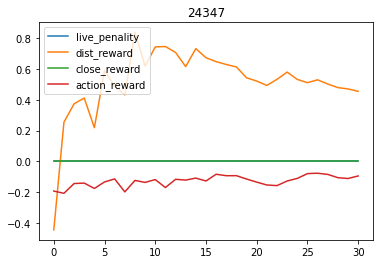

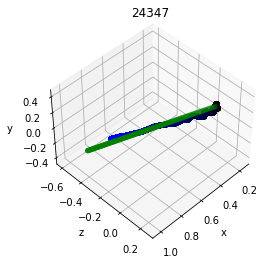

| eval  | E: 733 | S: 24347 | R: 12.0863
| train | E: 734 | S: 24347 | R: 10.4980 | D: 128.8 s | BR: 0.1458 | ALOSS: -10.4015 | CLOSS: 0.8841 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0205
| train | E: 735 | S: 24376 | R: 9.4551 | D: 335.0 s | BR: 0.1476 | ALOSS: -10.6352 | CLOSS: 1.1588 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0649
| train | E: 736 | S: 24408 | R: 7.0238 | D: 174.4 s | BR: 0.1495 | ALOSS: -10.3966 | CLOSS: 1.7334 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0546
| train | E: 737 | S: 24430 | R: 10.5497 | D: 117.6 s | BR: 0.1471 | ALOSS: -10.3662 | CLOSS: 1.3102 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0976
| train | E: 738 | S: 24466 | R: 7.5845 | D: 191.0 s | BR: 0.1244 | ALOSS: -9.9208 | CLOSS: 0.9317 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1141
| train | E: 739 | S: 24490 | R: 9.2039 | D: 129.2 s | BR: 0.1497 | ALOSS: -11.0006 | CLOSS: 0.8191 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1413
| train | E: 740 | S: 24512 | R: 10.4176 | D: 118.6 s | BR: 0.1503 | ALOSS: -11.07

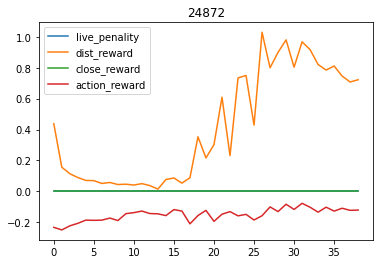

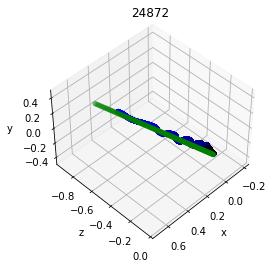

| eval  | E: 748 | S: 24872 | R: 10.3119
| train | E: 749 | S: 24872 | R: 2.1022 | D: 272.8 s | BR: 0.1369 | ALOSS: -10.0184 | CLOSS: 1.1902 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0531
| train | E: 750 | S: 24905 | R: 7.6369 | D: 398.2 s | BR: 0.1287 | ALOSS: -10.4359 | CLOSS: 0.7321 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0734
| train | E: 751 | S: 24935 | R: 5.9687 | D: 169.4 s | BR: 0.1535 | ALOSS: -11.0231 | CLOSS: 0.7220 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0693
| train | E: 752 | S: 24948 | R: 12.5644 | D: 68.0 s | BR: 0.1595 | ALOSS: -10.7359 | CLOSS: 1.3216 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0232
| train | E: 753 | S: 24963 | R: 12.7487 | D: 82.0 s | BR: 0.1481 | ALOSS: -10.6259 | CLOSS: 1.3757 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0687
| train | E: 754 | S: 24984 | R: 10.2598 | D: 119.3 s | BR: 0.1478 | ALOSS: -9.9349 | CLOSS: 0.7195 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0287
| train | E: 755 | S: 25028 | R: 4.5842 | D: 239.6 s | BR: 0.1476 | ALOSS: -10.5074

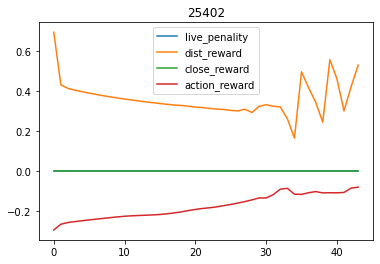

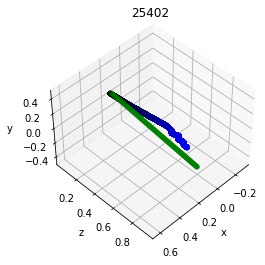

| eval  | E: 765 | S: 25402 | R: 8.1600
| train | E: 766 | S: 25402 | R: 7.6274 | D: 196.1 s | BR: 0.1519 | ALOSS: -10.3073 | CLOSS: 0.8600 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0102
| train | E: 767 | S: 25452 | R: -6.4576 | D: 520.5 s | BR: 0.1373 | ALOSS: -10.6945 | CLOSS: 0.9229 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0811
| train | E: 768 | S: 25492 | R: 3.8054 | D: 212.8 s | BR: 0.1292 | ALOSS: -10.6705 | CLOSS: 1.2793 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1363
| train | E: 769 | S: 25515 | R: 9.7347 | D: 125.4 s | BR: 0.1380 | ALOSS: -10.0973 | CLOSS: 1.4095 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0657
| train | E: 770 | S: 25565 | R: -10.5646 | D: 276.2 s | BR: 0.1493 | ALOSS: -10.9596 | CLOSS: 0.7990 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1603
| train | E: 771 | S: 25590 | R: 8.6693 | D: 138.5 s | BR: 0.1419 | ALOSS: -10.8030 | CLOSS: 1.2298 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1412
| train | E: 772 | S: 25621 | R: 8.0308 | D: 166.2 s | BR: 0.1490 | ALOSS: -10.57

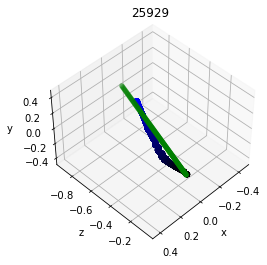

| eval  | E: 784 | S: 25929 | R: 8.7086
| train | E: 785 | S: 25929 | R: 4.6020 | D: 152.5 s | BR: 0.1677 | ALOSS: -11.4755 | CLOSS: 1.5048 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9324
| train | E: 786 | S: 25971 | R: 5.2201 | D: 493.0 s | BR: 0.1427 | ALOSS: -10.6725 | CLOSS: 1.6555 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9864
| train | E: 787 | S: 26021 | R: -0.6950 | D: 273.4 s | BR: 0.1507 | ALOSS: -9.6339 | CLOSS: 1.4842 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0419
| train | E: 788 | S: 26071 | R: 2.4378 | D: 272.6 s | BR: 0.1516 | ALOSS: -10.4523 | CLOSS: 1.1810 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0359
| train | E: 789 | S: 26099 | R: 8.4602 | D: 148.4 s | BR: 0.1406 | ALOSS: -10.6258 | CLOSS: 1.3418 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0428
| train | E: 790 | S: 26149 | R: 2.5766 | D: 271.6 s | BR: 0.1671 | ALOSS: -10.3298 | CLOSS: 1.1506 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0200
| train | E: 791 | S: 26183 | R: 5.6996 | D: 184.5 s | BR: 0.1228 | ALOSS: -10.7512 

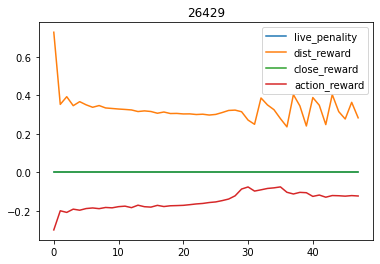

| eval  | E: 798 | S: 26429 | R: 8.7009
| train | E: 799 | S: 26429 | R: 10.6286 | D: 112.1 s | BR: 0.1254 | ALOSS: -10.7180 | CLOSS: 0.9469 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0241
| train | E: 800 | S: 26466 | R: 5.3649 | D: 463.6 s | BR: 0.1330 | ALOSS: -10.6777 | CLOSS: 0.8679 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0628
| train | E: 801 | S: 26485 | R: 7.5333 | D: 106.4 s | BR: 0.1650 | ALOSS: -10.2154 | CLOSS: 0.9331 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0776
| train | E: 802 | S: 26519 | R: 6.6147 | D: 185.0 s | BR: 0.1498 | ALOSS: -10.7609 | CLOSS: 0.9309 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0137
| train | E: 803 | S: 26553 | R: 7.2145 | D: 181.8 s | BR: 0.1359 | ALOSS: -11.1182 | CLOSS: 0.8486 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0291
| train | E: 804 | S: 26590 | R: 6.6241 | D: 197.8 s | BR: 0.1617 | ALOSS: -11.0952 | CLOSS: 0.5762 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0448
| train | E: 805 | S: 26603 | R: 11.7687 | D: 70.5 s | BR: 0.1303 | ALOSS: -10.5069

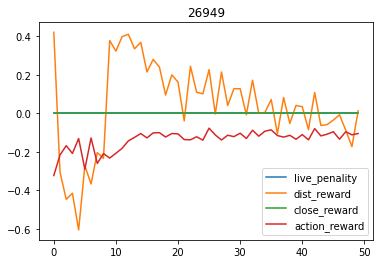

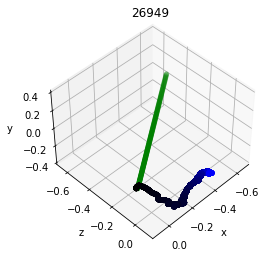

| eval  | E: 816 | S: 26949 | R: -4.8942
| train | E: 817 | S: 26949 | R: 9.9911 | D: 126.9 s | BR: 0.1334 | ALOSS: -9.7991 | CLOSS: 1.0422 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0975
| train | E: 818 | S: 26999 | R: -2.3932 | D: 567.3 s | BR: 0.1711 | ALOSS: -10.6533 | CLOSS: 0.7355 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1504
| train | E: 819 | S: 27036 | R: 5.2216 | D: 203.2 s | BR: 0.1387 | ALOSS: -11.6274 | CLOSS: 0.9740 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0794
| train | E: 820 | S: 27073 | R: 6.0347 | D: 210.9 s | BR: 0.1549 | ALOSS: -11.0323 | CLOSS: 0.7239 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0700
| train | E: 821 | S: 27101 | R: 8.0861 | D: 158.0 s | BR: 0.1375 | ALOSS: -11.2890 | CLOSS: 1.0249 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1329
| train | E: 822 | S: 27122 | R: 11.8620 | D: 110.6 s | BR: 0.1603 | ALOSS: -10.1688 | CLOSS: 0.9409 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1886
| train | E: 823 | S: 27149 | R: 9.0548 | D: 147.1 s | BR: 0.1411 | ALOSS: -10.316

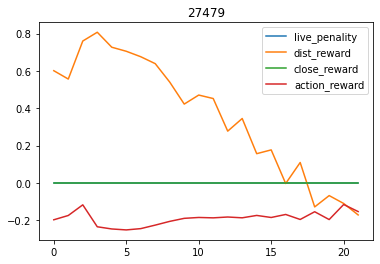

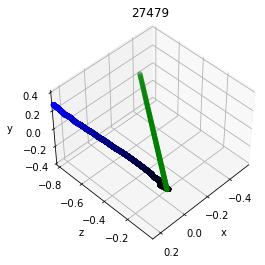

| eval  | E: 832 | S: 27479 | R: 3.7832
| train | E: 833 | S: 27479 | R: 8.5968 | D: 184.7 s | BR: 0.1794 | ALOSS: -11.2918 | CLOSS: 1.0119 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9721
| train | E: 834 | S: 27502 | R: 10.1790 | D: 241.5 s | BR: 0.1433 | ALOSS: -10.9423 | CLOSS: 0.7930 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0854
| train | E: 835 | S: 27525 | R: 10.2394 | D: 122.5 s | BR: 0.1420 | ALOSS: -10.4566 | CLOSS: 0.9631 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0761
| train | E: 836 | S: 27552 | R: 9.8230 | D: 152.6 s | BR: 0.1482 | ALOSS: -10.4323 | CLOSS: 0.8617 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1031
| train | E: 837 | S: 27583 | R: 7.7973 | D: 169.8 s | BR: 0.1461 | ALOSS: -11.0015 | CLOSS: 0.7572 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0227
| train | E: 838 | S: 27608 | R: 8.5458 | D: 135.3 s | BR: 0.1512 | ALOSS: -11.3355 | CLOSS: 0.7843 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0238
| train | E: 839 | S: 27626 | R: 11.5168 | D: 96.4 s | BR: 0.1828 | ALOSS: -11.046

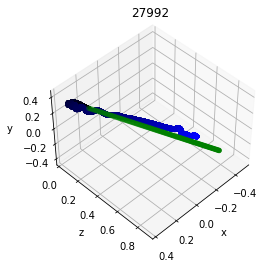

| eval  | E: 849 | S: 27992 | R: 7.8559
| train | E: 850 | S: 27992 | R: 2.3060 | D: 267.4 s | BR: 0.1581 | ALOSS: -10.3521 | CLOSS: 1.2286 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0235
| train | E: 851 | S: 28015 | R: 9.5291 | D: 395.9 s | BR: 0.1646 | ALOSS: -10.5391 | CLOSS: 0.8151 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0581
| train | E: 852 | S: 28040 | R: 9.9650 | D: 134.0 s | BR: 0.1591 | ALOSS: -11.0621 | CLOSS: 1.1858 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0921
| train | E: 853 | S: 28062 | R: 10.7897 | D: 122.3 s | BR: 0.1494 | ALOSS: -10.5768 | CLOSS: 0.9775 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1512
| train | E: 854 | S: 28089 | R: 8.4040 | D: 144.6 s | BR: 0.1581 | ALOSS: -10.5513 | CLOSS: 0.6217 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1032
| train | E: 855 | S: 28106 | R: 12.5756 | D: 90.8 s | BR: 0.1737 | ALOSS: -10.5381 | CLOSS: 0.6078 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1525
| train | E: 856 | S: 28124 | R: 11.5757 | D: 103.1 s | BR: 0.1390 | ALOSS: -11.005

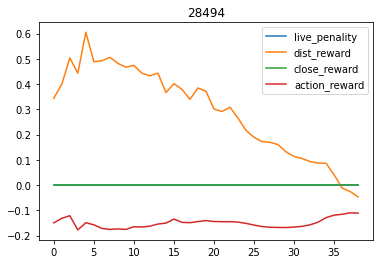

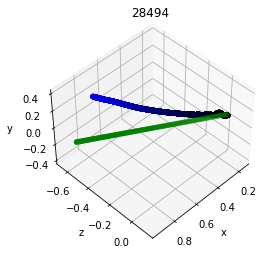

| eval  | E: 867 | S: 28494 | R: 5.5460
| train | E: 868 | S: 28494 | R: 9.1272 | D: 172.9 s | BR: 0.1490 | ALOSS: -9.9899 | CLOSS: 1.4691 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9718
| train | E: 869 | S: 28511 | R: 11.0674 | D: 313.7 s | BR: 0.2015 | ALOSS: -9.8423 | CLOSS: 1.0241 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 1.9904
| train | E: 870 | S: 28542 | R: 8.0085 | D: 168.5 s | BR: 0.1460 | ALOSS: -10.0235 | CLOSS: 1.2590 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0757
| train | E: 871 | S: 28566 | R: 9.8946 | D: 139.6 s | BR: 0.1643 | ALOSS: -10.4500 | CLOSS: 1.1519 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0487
| train | E: 872 | S: 28586 | R: 8.7561 | D: 112.4 s | BR: 0.1200 | ALOSS: -11.1181 | CLOSS: 1.2938 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0546
| train | E: 873 | S: 28621 | R: 6.9055 | D: 199.2 s | BR: 0.1484 | ALOSS: -10.9801 | CLOSS: 1.0741 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0522
| train | E: 874 | S: 28658 | R: 6.6653 | D: 209.1 s | BR: 0.1658 | ALOSS: -10.5310 |

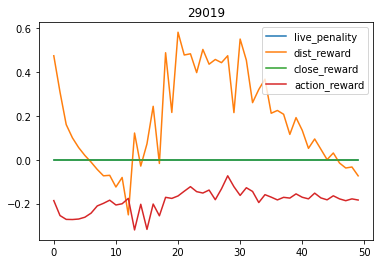

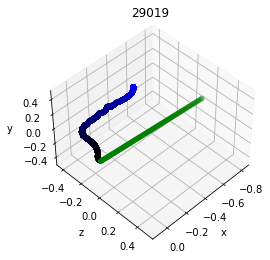

| eval  | E: 884 | S: 29019 | R: -0.2268
| train | E: 885 | S: 29019 | R: 4.5416 | D: 240.7 s | BR: 0.1608 | ALOSS: -10.1590 | CLOSS: 0.9080 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1007
| train | E: 886 | S: 29039 | R: 10.4325 | D: 380.0 s | BR: 0.1296 | ALOSS: -9.9752 | CLOSS: 0.6909 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1257
| train | E: 887 | S: 29083 | R: 4.9985 | D: 235.1 s | BR: 0.1538 | ALOSS: -10.1319 | CLOSS: 1.0391 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1734
| train | E: 888 | S: 29108 | R: 9.7400 | D: 133.2 s | BR: 0.1578 | ALOSS: -10.0411 | CLOSS: 1.1482 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1509
| train | E: 889 | S: 29158 | R: -7.0992 | D: 289.6 s | BR: 0.1560 | ALOSS: -10.4647 | CLOSS: 1.0935 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0942
| train | E: 890 | S: 29177 | R: 10.5054 | D: 106.8 s | BR: 0.1383 | ALOSS: -11.2575 | CLOSS: 0.7498 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0344
| train | E: 891 | S: 29202 | R: 7.7870 | D: 141.6 s | BR: 0.1841 | ALOSS: -10.40

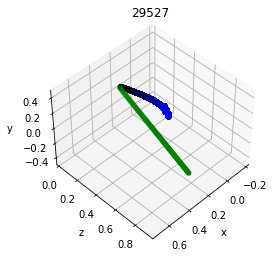

| eval  | E: 900 | S: 29527 | R: 1.3709
| train | E: 901 | S: 29527 | R: 5.3885 | D: 227.0 s | BR: 0.1655 | ALOSS: -10.3632 | CLOSS: 0.8365 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1360
| train | E: 902 | S: 29559 | R: 7.8440 | D: 445.9 s | BR: 0.1609 | ALOSS: -10.3247 | CLOSS: 0.9042 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1129
| train | E: 903 | S: 29609 | R: -7.4478 | D: 273.8 s | BR: 0.1431 | ALOSS: -10.9097 | CLOSS: 1.1425 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1101
| train | E: 904 | S: 29645 | R: 5.6298 | D: 195.5 s | BR: 0.1497 | ALOSS: -10.3864 | CLOSS: 1.1367 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1358
| train | E: 905 | S: 29675 | R: 7.9559 | D: 166.3 s | BR: 0.1597 | ALOSS: -10.4647 | CLOSS: 0.9919 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1324
| train | E: 906 | S: 29716 | R: 4.8365 | D: 219.3 s | BR: 0.1566 | ALOSS: -10.6412 | CLOSS: 1.1861 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.1196
| train | E: 907 | S: 29739 | R: 6.2597 | D: 126.8 s | BR: 0.1744 | ALOSS: -11.0459

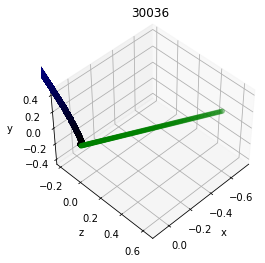

| eval  | E: 916 | S: 30036 | R: -35.7001
| train | E: 917 | S: 30036 | R: 8.3968 | D: 158.7 s | BR: 0.1592 | ALOSS: -10.8199 | CLOSS: 1.2765 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0913
| train | E: 918 | S: 30079 | R: 4.4215 | D: 517.9 s | BR: 0.1395 | ALOSS: -11.1174 | CLOSS: 1.5690 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0669
| train | E: 919 | S: 30129 | R: -2.2382 | D: 273.2 s | BR: 0.1639 | ALOSS: -11.0782 | CLOSS: 0.6201 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0470
| train | E: 920 | S: 30147 | R: 9.6582 | D: 102.7 s | BR: 0.1332 | ALOSS: -11.1792 | CLOSS: 1.0909 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0492
| train | E: 921 | S: 30174 | R: 9.3754 | D: 141.9 s | BR: 0.1646 | ALOSS: -10.6429 | CLOSS: 0.9852 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0948
| train | E: 922 | S: 30196 | R: 10.5771 | D: 126.9 s | BR: 0.1617 | ALOSS: -10.7010 | CLOSS: 0.6264 | TLOSS: 0.0000 | TVAL: 0.0000 | AENT: 2.0738
| train | E: 923 | S: 30229 | R: 6.9937 | D: 180.8 s | BR: 0.1799 | ALOSS: -10.6

KeyboardInterrupt: 

In [26]:
while step < num_train_steps:
    samples = collect_traj()
    for sample in samples:
        obs,action,next_obs,reward,done = sample
        if done:
            logger.log('train/duration',time.time() - start_time, step)
            start_time = time.time()
            # evaluate agent periodically
            if step >=next_eval_steps:
                # save model
                agent.save(model_folder+"steps_{0}".format(step))
                logger.log('eval/episode', episode, step)
                next_eval_steps = step+eval_frequency
                evaluate()
            logger.log('train/episode_reward', episode_reward,step)
            episode_reward = 0
            episode += 1
            logger.log('train/episode', episode, step)
            logger.dump(step, save=True,ty='train')
        # run training update
        agent.update(logger, step)  
        done = float(done)
        episode_reward += reward
        step += 1
        agent.replay_buffer.add(obs, action, reward, next_obs, done,done)

In [ ]:
torch.save({'buffer':agent.replay_buffer},model_folder+'buffer')
torch.save({'actor':agent.actor.state_dict()},model_folder+'actor')
agent.save(model_folder+'model')

In [ ]:
network_folder

## Evaluation and Test

In [ ]:
evaluate_save_fluid=False
evaluate_save_data=True

In [ ]:
def evaluate_traj(theta,dist):
        print("Evaluating episode  ...."+str(theta))
        obs = env.reset()
        env.set_task(theta,dist)
        ref_line = fl.debugLine()
        ref_line.vertices = [
                    env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
                ]
        fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")
        agent.reset()
        done = False
        episode_reward = 0
        infos = []
        while not done:
            with utils.eval_mode(agent):
                action = agent.act(obs, sample=False)
            if evaluate_save_data:
                obs, reward, done, info = env.stepSave(action,save_fluid=evaluate_save_fluid)
            else:
                obs, reward, done, info = env.step(action)
            infos.append(info)
            # video_recorder.record(env)
            episode_reward += reward
        print(episode_reward)
#         plot_infos(infos,title=str(theta))
        env.plot3d(title=str(theta))

In [ ]:
!./clean_visdata.sh
evaluate_traj(0,0.01)

In [ ]:
ref_line = fl.debugLine()
ref_line.vertices = [
            env.path_start*(1.0-t)+env.goal_pos*t for t in np.arange(0.0,1.0,1.0/100)
        ]
fl.VTKWriter.writeLines([ref_line], env.dataPath["trajectory"]+"/trajectory_ideal.vtk")

In [27]:
from matplotlib.patches import FancyArrowPatch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.proj3d import proj_transform
from mpl_toolkits.mplot3d.axes3d import Axes3D
class Arrow3D(FancyArrowPatch):
    def __init__(self, x, y, z, dx, dy, dz, *args, **kwargs):
        super().__init__((0,0), (0,0), *args, **kwargs)
        self._xyz = (x,y,z)
        self._dxdydz = (dx,dy,dz)

    def draw(self, renderer):
        x1,y1,z1 = self._xyz
        dx,dy,dz = self._dxdydz
        x2,y2,z2 = (x1+dx,y1+dy,z1+dz)

        xs, ys, zs = proj_transform((x1,x2),(y1,y2),(z1,z2), renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        super().draw(renderer)
def _arrow3D(ax, x, y, z, dx, dy, dz, *args, **kwargs):
    '''Add an 3d arrow to an `Axes3D` instance.'''
    arrow = Arrow3D(x, y, z, dx, dy, dz, *args, **kwargs)
    ax.add_artist(arrow)
setattr(Axes3D,'arrow3D',_arrow3D)

In [28]:
%matplotlib notebook

In [29]:
from gym_fish.envs.py_util import flare_util
from gym_fish.envs.lib import pyflare as fl

In [39]:
# fluid_json = json_folder+'fluid_param_0.5.json'
# rigid_json = json_folder+'rigids_4_30_test.json'
# frame_skip = 100
from gym_fish.envs import FishEnv
env=gym.make('fish-v0', 
                  gpuId=gpuId,
                        couple_mode=couple_mode,frame_skip=frame_skip,radius=radius,
                       theta=theta,action_max=action_max,random_vel=random_vel,max_time=max_time,
                       fluid_json=fluid_json,wp=wp,wr=wr,wa=wa,live_penality =live_penality,
                       rigid_json=rigid_json,vel_theta = vel_theta,
                       done_dist=done_dist,dist_distri_param=dist_distri_param,use_com=use_com
               
                   )
env.plot3d()

<IPython.core.display.Javascript object>

In [40]:
### test generalization to sequence goals
path = flare_util.path_data()
path.from_json(str(Path("./py_data/jsons/paths/path_zzz.json").resolve()))
traj  =  path.trajectory
paths_by_t= np.array([ traj.getPose(t).getPosition()  for t in np.arange(0.0,1.0,1.0/100) ])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X = paths_by_t[:,0]
Y = paths_by_t[:,1]
Z = paths_by_t[:,2]
ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max() / 2.0
mid_x = (X.max()+X.min()) * 0.5
mid_y = (Y.max()+Y.min()) * 0.5
mid_z = (Z.max()+Z.min()) * 0.5
ax.set_xlim(mid_x - max_range, mid_x + max_range)
ax.set_ylim(mid_z - max_range, mid_z + max_range)
ax.set_zlim(mid_y - max_range, mid_y + max_range)
plt.show()

<IPython.core.display.Javascript object>

In [41]:
def plot_env(env,ax):
    ax.clear()
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_z - max_range, mid_z + max_range)
    ax.set_zlim(mid_y - max_range, mid_y + max_range)
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.view_init(elev=45,azim=45)#改变绘制图像的视角,即相机的位置,azim沿着z轴旋转，elev沿着y轴
    dxyz = env.goal_pos-env.body_xyz
    fwd = env.rigid_data.skeletons[0].dynamics.getBaseLinkFwd()
    right = env.rigid_data.skeletons[0].dynamics.getBaseLinkRight()
    up = env.rigid_data.skeletons[0].dynamics.getBaseLinkUp()
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],fwd[0],fwd[2],fwd[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='red')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],right[0],right[2],right[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='green')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],up[0],up[2],up[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='blue')
    ax.arrow3D(env.body_xyz[0],env.body_xyz[2],env.body_xyz[1],dxyz[0],dxyz[2],dxyz[1],arrowstyle="-|>",ec ='green',mutation_scale=20,
           fc='yellow',)
    ax.scatter3D(xs=X, zs=Y, ys=Z,c=[[0,i/len(paths_by_t),0] for i in range(paths_by_t.shape[0])])
    fig.canvas.draw()

rm: cannot remove './data/vis_data/Objects/*': No such file or directory
rm: cannot remove './data/vis_data/Fluid/*': No such file or directory


<IPython.core.display.Javascript object>


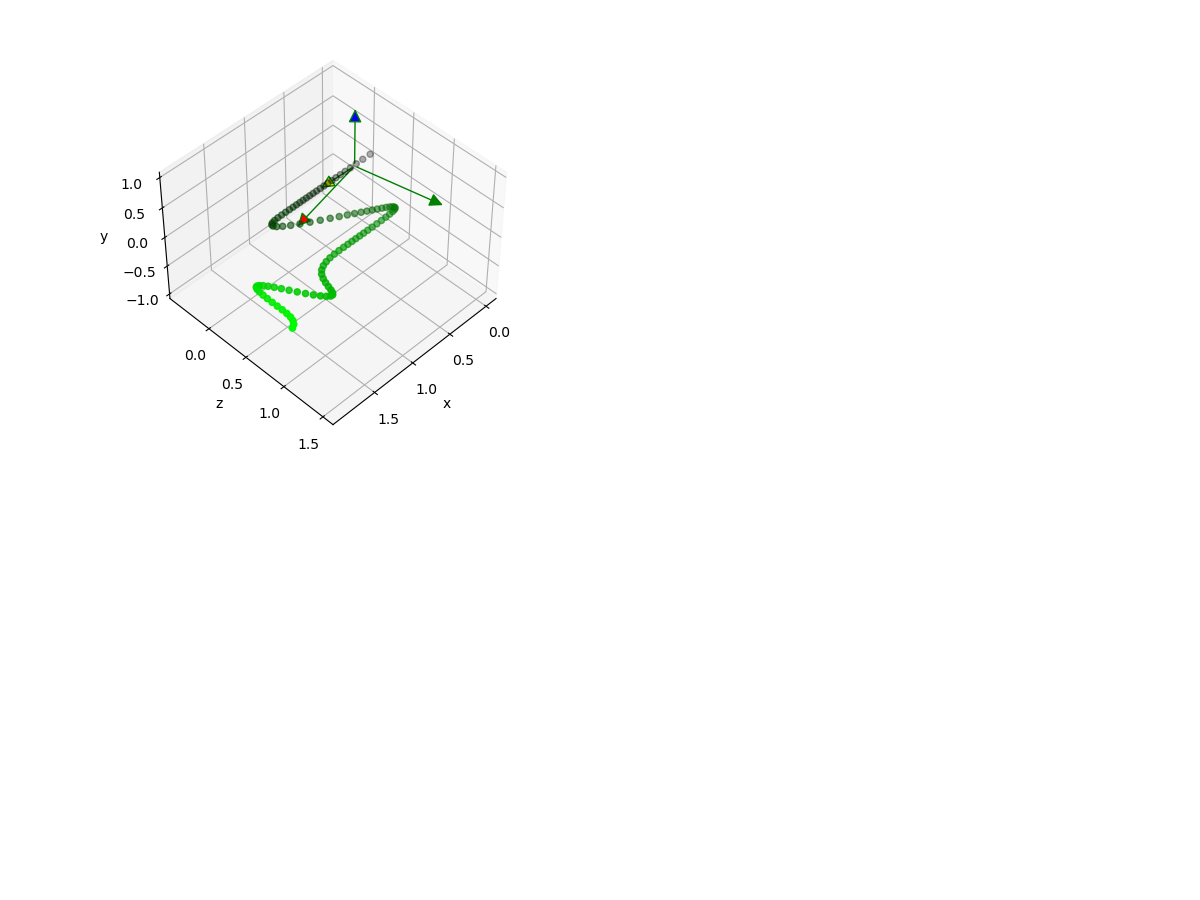

KeyboardInterrupt: 

In [43]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
env.training = False
skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
skeleton_dynamics.getJoint("head").setVelocity(0,0)
skeleton_dynamics.getJoint("head").setVelocity(1,0)
joint_list =['spine','spine01','spine02','spine03']
for jnt_name in joint_list:
    skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
    skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)


skeleton_dynamics.update()

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()
env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.path_start  = env.body_xyz 
env.path_dir = env.goal_pos-env.path_start
env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)

# skeleton_dynamics.setHead(path_position_begin,path_orientation_begin)
env.simulator.mainDataFolderPath = store_folder+'/data/'
env.dataPath = {}
env.dataPath["fluid"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.fluidFolderName + '/').resolve())
env.dataPath["objects"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.objectsFolderName + '/').resolve())
env.dataPath["trajectory"] = str(Path(env.simulator.mainDataFolderPath + 'Trajectory/').resolve())
if not os.path.exists(env.simulator.mainDataFolderPath):
    os.makedirs(env.simulator.mainDataFolderPath)
for p in env.dataPath.values():
    if not os.path.exists(p):
        os.makedirs(p)



        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
actions= []
observations = []
vels = []
while True:
    if env.rigid_data.rigidWorld.time>50 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break 
    obs = env._get_obs()
    observations.append(obs)
    with utils.eval_mode(agent):
        action = agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    env.stepSave(action,save_objects=True,save_fluid=False,test_mode=True)
    
    rela_vec_to_goal = env.goal_pos-env.body_xyz
    dist_to_path = np.linalg.norm(rela_vec_to_goal-env.path_dir*np.dot(rela_vec_to_goal,env.path_dir))
    env.proj_pt_world = env.goal_pos-env.path_dir*np.dot(rela_vec_to_goal,env.path_dir)
    if np.linalg.norm(env.body_xyz-env.goal_pos)<0.3:
        t = t+dt
        env.goal_pos = traj.getPose(t).getPosition() 
        env.path_start  = env.body_xyz 
        env.path_dir = env.goal_pos-env.path_start
        env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)
    plot_env(env,ax)
plt.close(fig)


In [62]:
        
while env.rigid_data.rigidWorld.time<10:
    env.stepSave(np.ones(env.action_dim)*0,save_objects=True,save_fluid=False,test_mode=True)

In [60]:
env.couple_mode =  fl.COUPLE_MODE.TWO_WAY
fl.VTKWriter.writeTrajectory(traj, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
env.training = False
# skeleton_dynamics = env.rigid_data.skeletons[0].dynamics
# skeleton_dynamics.getJoint("head").setVelocity(0,0)
# skeleton_dynamics.getJoint("head").setVelocity(1,0)
# joint_list =['spine','spine01','spine02','spine03']
# for jnt_name in joint_list:
#     skeleton_dynamics.getJoint(jnt_name).setPosition(0,0)
#     skeleton_dynamics.getJoint(jnt_name).setVelocity(0,0)

# skeleton_dynamics.update()

t = 0.001
dt = 0.08

startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()
skeleton_dynamics.setHead(path_position_begin,path_orientation_begin)


env.simulator.mainDataFolderPath = store_folder+'/data/'
env.dataPath = {}
env.dataPath["fluid"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.fluidFolderName + '/').resolve())
env.dataPath["objects"] = str(Path(env.simulator.mainDataFolderPath + env.simulator.objectsFolderName + '/').resolve())
env.dataPath["trajectory"] = str(Path(env.simulator.mainDataFolderPath + 'Trajectory/').resolve())
if not os.path.exists(env.simulator.mainDataFolderPath):
    os.makedirs(env.simulator.mainDataFolderPath)
for p in env.dataPath.values():
    if not os.path.exists(p):
        os.makedirs(p)



env.goal_pos = traj.getPose(traj.getReferencePose(env.body_xyz)+dt).getPosition() 
env.path_start  = env.body_xyz 
env.path_dir = env.goal_pos-env.path_start
env.path_dir = env.path_dir/np.linalg.norm(env.path_dir)
        
while env.rigid_data.rigidWorld.time<3:
    env.stepSave(np.ones(env.action_dim)*0,save_objects=True,save_fluid=False,test_mode=True)

<IPython.core.display.Javascript object>


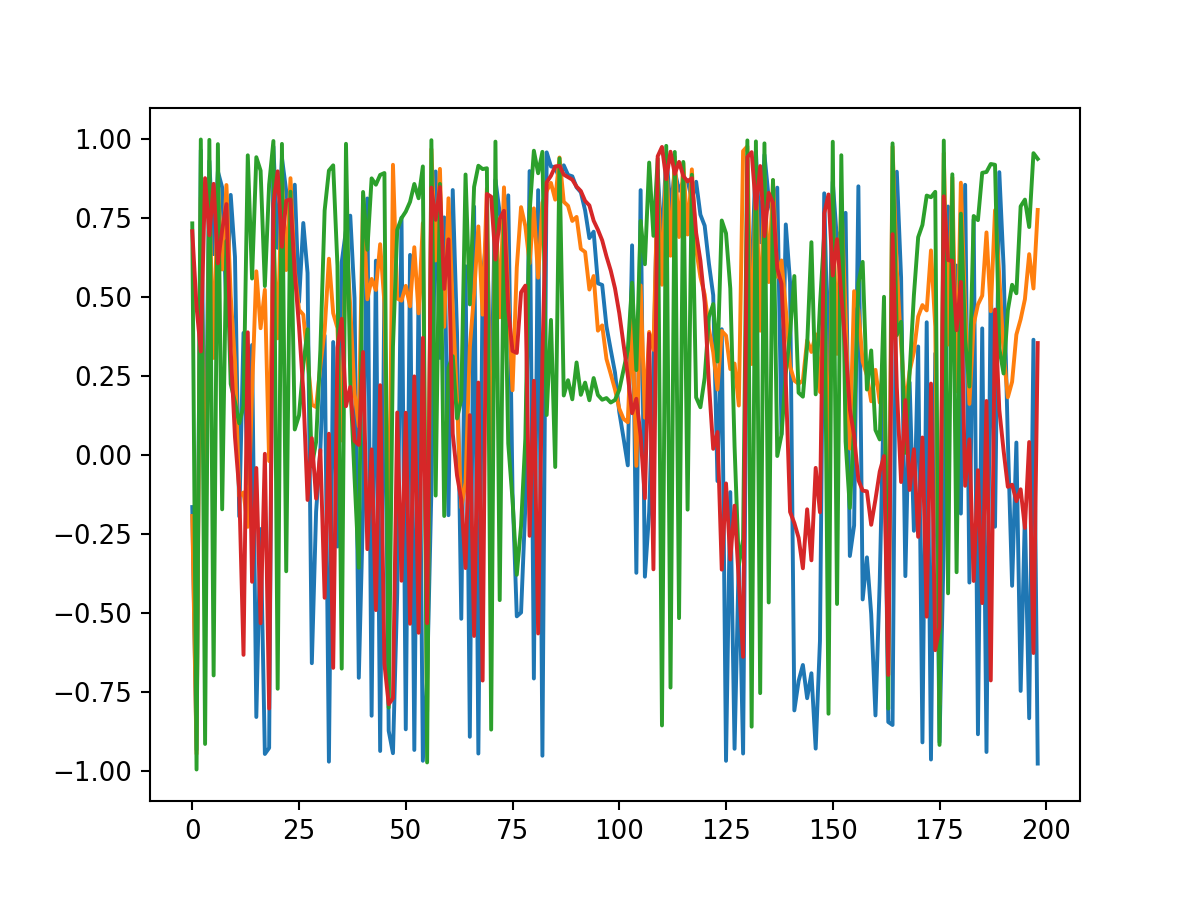

<IPython.core.display.Javascript object>


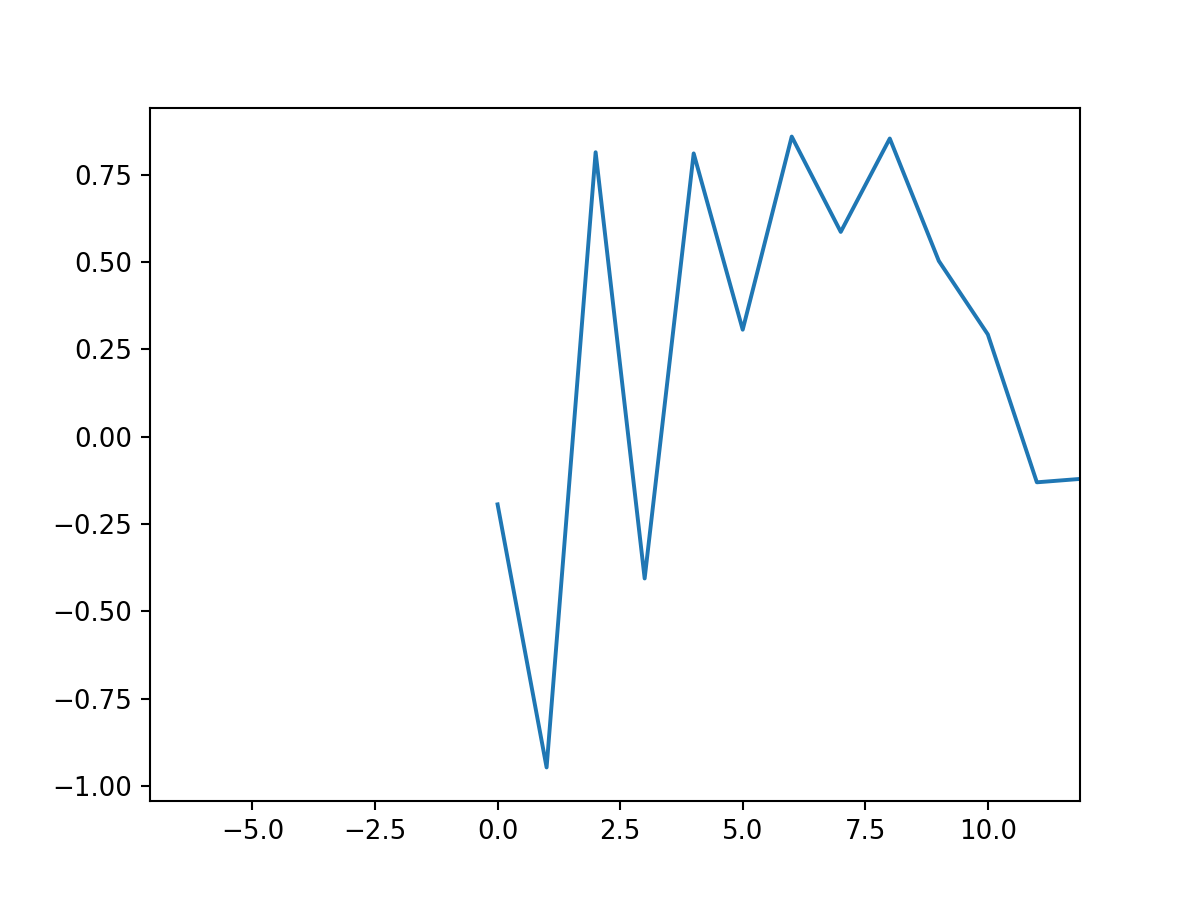

In [46]:
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),vels)
# plt.show()
plt.figure()
plt.plot(np.arange(0,len(actions),1),actions)
plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
# plt.show()
# plt.figure()
# plt.plot(np.arange(0,len(observations),1),np.array(observations))
# plt.show()
plt.figure()
# plt.plot(np.arange(0,len(actions),1),[ 0.1* np.sum(np.abs(a)**2) for a in actions])
plt.plot(np.arange(0,len(actions),1),[ a[1] for a in actions])
plt.show()

In [ ]:
!./clean_visdata.sh
fl.VTKWriter.writeTrajectory(env.path_data.trajectory, env.dataPath['trajectory'] + '/trajectory.vtk')
env.reset()
dones = False
infos = []
reward = 0
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(0,0)
env.rigid_data.skeletons[0].dynamics.getJoint("head").setVelocity(1,0)

t = 0.001
dt = 0.08
startPose = traj.getPose(t)
path_position_begin = startPose.getPosition()
path_orientation_begin = startPose.getOrientation()

env.init_pos = path_position_begin
env.set_theta(0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion()
    

actions= []
observations = []
vels = []
while not dones:
    obs = env._get_obs()
    observations.append(obs)
    if env.rigid_data.rigidWorld.time>20:
#     if env.rigid_data.rigidWorld.time>100 or traj.getReferencePose(env.body_xyz) >0.98:
        print("Time exceed! ",t,traj.getReferencePose(env.body_xyz),env.rigid_data.rigidWorld.time)
        break
    with utils.eval_mode(ws.agent):
        action = ws.agent.act(obs, sample=False)
    actions.append(action)
    vels.append(env.rigid_data.skeletons[0].dynamics.getVelocities(includeBase=False))
    _,_,_,_=env.stepSave(action,save_objects=False,save_fluid=False)
    env.goal_pos = env.body_xyz+env.goal_dir*2.0
    plot_env(env,ax)
plt.close(fig)


In [ ]:
plt.figure()
plt.plot(np.arange(0,len(vels),1),np.array(actions)/np.array(vels)[:,:4])
plt.show()